# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the libraries you will be using for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [5]:
# Try loading one file

#df = pd.read_parquet('/content/drive/MyDrive/Datasets and Dictionary/trip_records/2023-1.parquet')
#df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [6]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/MyDrive/Datasets and Dictionary/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        month_df = pd.read_parquet(file_path)

        # Convert datetime column
        month_df['tpep_pickup_datetime'] = pd.to_datetime(month_df['tpep_pickup_datetime'])
        # Extract date and hour
        month_df['date'] = month_df['tpep_pickup_datetime'].dt.date
        month_df['hour'] = month_df['tpep_pickup_datetime'].dt.hour


        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for curr_date in month_df['date'].unique():

            date_df = month_df[month_df['date'] == curr_date]

            # Iterate through each hour of the selected date
            for hr in range(24):

                hour_df = date_df[date_df['hour'] == hr]

                if len(hour_df) > 0:
                    # Sample 5% of the hourly data randomly
                    sampled_hour = hour_df.sample(
                        frac=0.05,
                        random_state=42
                    )
                   # add data of this hour to the dataframe
                    sampled_data = pd.concat(
                        [sampled_data, sampled_hour],
                        ignore_index=True
                    )


        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data], ignore_index=True)
        print(f"Processed file: {file_name}")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")


Processed file: 2023-9.parquet
Processed file: 2023-5.parquet
Processed file: 2023-6.parquet
Processed file: 2023-2.parquet
Processed file: 2023-8.parquet
Processed file: 2023-1.parquet
Processed file: 2023-7.parquet
Processed file: 2023-10.parquet
Processed file: 2023-3.parquet
Processed file: 2023-12.parquet
Processed file: 2023-4.parquet
Processed file: 2023-11.parquet
Processed file: 2023-1to12.parquet
Error reading file 2023-1to12.csv: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [9]:
# Store the df in csv/parquet
#df.to_parquet('/content/drive/MyDrive/Datasets and Dictionary/trip_records/2023-1to12.parquet')
#df.to_csv('/content/drive/MyDrive/Datasets and Dictionary/trip_records/2023-1to12.csv')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [10]:
# Load the new data file

df = pd.read_parquet('/content/drive/MyDrive/Datasets and Dictionary/trip_records/2023-1to12.parquet')


In [11]:
df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,...,0.5,4.32,0.00,1.0,33.15,NaN,NaN,2023-09-01,0,NaN
1,2,2023-09-01 00:24:50,2023-09-01 00:27:19,2.0,0.56,1.0,N,142,142,2,...,0.5,0.00,0.00,1.0,10.10,2.5,0.00,2023-09-01,0,NaN
2,2,2023-09-01 00:19:27,2023-09-01 01:04:02,2.0,18.46,2.0,N,132,163,1,...,0.5,15.71,6.94,1.0,98.40,2.5,1.75,2023-09-01,0,NaN
3,2,2023-09-01 00:42:13,2023-09-01 01:20:20,2.0,13.71,1.0,N,249,180,4,...,0.5,0.00,0.00,1.0,64.70,2.5,0.00,2023-09-01,0,NaN
4,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,...,0.5,2.00,0.00,1.0,14.90,2.5,0.00,2023-09-01,0,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [13]:
# Fix the index and drop any columns that are not needed

df.drop(
    columns=[
        'date',         # derived
        'hour'          # derived
    ],
    inplace=True
)
# Reset index
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,24.83,0.0,0.5,4.32,0.00,1.0,33.15,NaN,NaN,NaN
1,2,2023-09-01 00:24:50,2023-09-01 00:27:19,2.0,0.56,1.0,N,142,142,2,5.10,1.0,0.5,0.00,0.00,1.0,10.10,2.5,0.00,NaN
2,2,2023-09-01 00:19:27,2023-09-01 01:04:02,2.0,18.46,2.0,N,132,163,1,70.00,0.0,0.5,15.71,6.94,1.0,98.40,2.5,1.75,NaN
3,2,2023-09-01 00:42:13,2023-09-01 01:20:20,2.0,13.71,1.0,N,249,180,4,59.70,1.0,0.5,0.00,0.00,1.0,64.70,2.5,0.00,NaN
4,2,2023-09-01 00:11:38,2023-09-01 00:17:56,1.0,0.71,1.0,N,144,232,1,7.90,1.0,0.5,2.00,0.00,1.0,14.90,2.5,0.00,NaN


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [15]:
# Combine the two airport fee columns
df[['Airport_fee', 'airport_fee']].info()
both_non_null = df[
    df['Airport_fee'].notna() & df['airport_fee'].notna()
]

both_non_null.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Airport_fee  float64
 1   airport_fee  float64
dtypes: float64(2)
memory usage: 28.9 MB


(0, 20)

In [16]:
mismatch = both_non_null[
    df['Airport_fee'] != df['airport_fee']
]

mismatch.shape


(0, 20)

In [17]:
df['airport_fee_clean'] = (
    df['airport_fee']
    .combine_first(df['Airport_fee'])
)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [19]:
df.drop(columns=['Airport_fee', 'airport_fee'], inplace=True)

df.rename(
    columns={'airport_fee_clean': 'airport_fee'},
    inplace=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [20]:
negative_fares = df[df['fare_amount'] < 0]

In [21]:
# check where values of fare amount are negative

negative_fares[
    ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
     'fare_amount', 'total_amount', 'trip_distance']
].head()

negative_fares.shape

(0, 19)

In [22]:
negative_fares.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [23]:
(df['fare_amount'] < 0).any()


np.False_

In [24]:
df['fare_amount'].min()

0.0

In [25]:
(df['fare_amount'] == 0).sum()

np.int64(651)

In [26]:
df[df['fare_amount'] == 0].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2487,1,2023-09-01 16:55:39,2023-09-01 17:07:19,2.0,2.80,5.0,N,132,132,2,0.0,1.75,0.0,0.0,0.0,1.0,2.75,0.0,1.75
6836,1,2023-09-02 17:10:34,2023-09-02 17:11:12,3.0,0.00,5.0,N,161,161,2,0.0,0.00,0.0,0.0,0.0,1.0,1.00,0.0,0.00
7156,2,2023-09-02 18:29:48,2023-09-02 18:30:13,3.0,0.00,2.0,N,74,74,2,0.0,0.00,-0.5,0.0,0.0,-1.0,-1.50,0.0,0.00
16181,2,2023-09-05 07:47:58,2023-09-05 08:01:51,1.0,1.16,2.0,N,230,230,2,0.0,0.00,0.5,0.0,0.0,1.0,4.00,2.5,0.00
17307,1,2023-09-05 11:01:20,2023-09-05 11:02:30,1.0,0.00,5.0,N,132,132,3,0.0,1.75,0.0,0.0,0.0,1.0,2.75,0.0,1.75


Did you notice something different in the `RatecodeID` column for above records?

In [27]:
# Analyse RatecodeID for the negative fare amounts
# There are no negative fare amounts in the dataset

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [29]:
# Find which columns have negative values
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols


Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [30]:
negative_columns = {
    col: (df[col] < 0).sum()
    for col in numeric_cols
    if (df[col] < 0).any()
}

negative_columns


{'extra': np.int64(3),
 'mta_tax': np.int64(73),
 'improvement_surcharge': np.int64(78),
 'total_amount': np.int64(78),
 'congestion_surcharge': np.int64(56),
 'airport_fee': np.int64(15)}

In [31]:
negative_summary = (
    pd.Series(negative_columns, name='Negative_Count')
      .reset_index()
      .rename(columns={'index': 'Column'})
)

negative_summary

,Column,Negative_Count
0,extra,3
1,mta_tax,73
2,improvement_surcharge,78
3,total_amount,78
4,congestion_surcharge,56
5,airport_fee,15


In [32]:
# fix these negative values
#Set the fee components to zero as they cannot be negative
fee_columns = [
    'extra',
    'mta_tax',
    'improvement_surcharge',
    'congestion_surcharge',
    'airport_fee'
]

for col in fee_columns:
    df.loc[df[col] < 0, col] = 0

# Negative total amount makes the trip invalid, remove it
df = df[df['total_amount'] >= 0].reset_index(drop=True)


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [33]:
# Find the proportion of missing values in each column

missing_proportion = df.isna().mean().sort_values(ascending=False)
missing_proportion


,0
store_and_fwd_flag,0.03421
RatecodeID,0.03421
passenger_count,0.03421
airport_fee,0.03421
congestion_surcharge,0.03421
VendorID,0.00000
tpep_pickup_datetime,0.00000
tpep_dropoff_datetime,0.00000
DOLocationID,0.00000
PULocationID,0.00000


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [34]:
# Display the rows with null values
rows_with_nulls = df[df.isna().any(axis=1)]
rows_with_nulls
rows_with_nulls.shape


(64874, 19)

In [35]:
# Impute NaN values in 'passenger_count'
df[df['passenger_count'].isna()]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-09-01 00:39:59,2023-09-01 01:00:28,NaN,4.71,NaN,None,113,238,0,24.83,0.0,0.5,4.32,0.0,1.0,33.15,NaN,NaN
85,2,2023-09-01 00:01:15,2023-09-01 00:07:07,NaN,1.07,NaN,None,148,4,0,11.88,0.0,0.5,2.00,0.0,1.0,17.88,NaN,NaN
151,2,2023-09-01 01:58:13,2023-09-01 02:12:29,NaN,3.32,NaN,None,211,230,0,19.04,0.0,0.5,4.61,0.0,1.0,27.65,NaN,NaN
203,2,2023-09-01 01:08:34,2023-09-01 01:20:38,NaN,2.67,NaN,None,144,65,0,19.89,0.0,0.5,4.30,0.0,1.0,28.19,NaN,NaN
251,1,2023-09-01 02:29:04,2023-09-01 02:45:34,NaN,0.00,NaN,None,79,48,0,19.85,0.0,0.5,0.00,0.0,1.0,23.85,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896295,2,2023-11-30 23:38:07,2023-11-30 23:50:50,NaN,1.35,NaN,None,161,164,0,14.62,0.0,0.5,0.00,0.0,1.0,18.62,NaN,NaN
1896298,1,2023-11-30 23:49:26,2023-11-30 23:56:00,NaN,0.00,NaN,None,114,148,0,18.20,0.0,0.5,0.00,0.0,1.0,22.20,NaN,NaN
1896313,2,2023-11-30 23:44:13,2023-11-30 23:52:02,NaN,1.01,NaN,None,161,141,0,11.33,0.0,0.5,0.00,0.0,1.0,15.33,NaN,NaN
1896314,2,2023-11-30 23:17:41,2023-11-30 23:32:07,NaN,3.64,NaN,None,80,45,0,25.09,0.0,0.5,0.00,0.0,1.0,29.09,NaN,NaN


In [36]:
median_passenger_count = df['passenger_count'].median()
print(median_passenger_count)
df['passenger_count'] = df['passenger_count'].fillna(median_passenger_count)



1.0


In [37]:
df[df['passenger_count'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [38]:
df['passenger_count'].value_counts(dropna=False)


,count
passenger_count,
1.0,1442043
2.0,277283
3.0,69032
4.0,38532
0.0,29681
5.0,23871
6.0,15859
8.0,11
7.0,5


Did you find zeroes in passenger_count? Handle these.

In [39]:
#passenger_count = 0 is considered as data entry errors and it is imputed to 1
df.loc[df['passenger_count'] == 0, 'passenger_count'] = 1

In [40]:
df['passenger_count'].value_counts(dropna=False)

,count
passenger_count,
1.0,1471724
2.0,277283
3.0,69032
4.0,38532
5.0,23871
6.0,15859
8.0,11
7.0,5
9.0,5


**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [41]:
df['RatecodeID'].value_counts(dropna=False)

,count
RatecodeID,
1.0,1729210
2.0,71646
NaN,64874
99.0,10472
5.0,10272
3.0,6123
4.0,3722
6.0,3


In [42]:
# Fix missing values in 'RatecodeID' with mode
ratecode_mode = df['RatecodeID'].mode()[0]
print(ratecode_mode)
df['RatecodeID'] = df['RatecodeID'].fillna(ratecode_mode)



1.0


In [43]:
df['RatecodeID'].isna().sum()

np.int64(0)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [44]:
df['congestion_surcharge'].value_counts(dropna=False)

,count
congestion_surcharge,
2.5,1690572
0.0,140875
NaN,64874
0.5,1


In [45]:
# handle null values in congestion_surcharge by filling with zero

df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0.0)



In [46]:
df['congestion_surcharge'].isna().sum()

np.int64(0)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [47]:
# Handle any remaining missing values

df.isna().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
RatecodeID,0
store_and_fwd_flag,64874
PULocationID,0
DOLocationID,0
payment_type,0


In [48]:
df['store_and_fwd_flag'].value_counts(dropna=False)

,count
store_and_fwd_flag,
N,1820209
None,64874
Y,11239


In [49]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('N')

In [50]:
df['store_and_fwd_flag'].isna().sum()

np.int64(0)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [51]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns



In [52]:
#Passenger count 1-6
df[
    (df['passenger_count'] < 1) |
    (df['passenger_count'] > 6)
][['passenger_count']].value_counts()

,count
passenger_count,
8.0,11
7.0,5
9.0,5


In [53]:
df[
    (df['trip_distance'] <= 0) |
    (df['trip_distance'] > 250)
][['trip_distance']].describe()


,trip_distance
count,37758.000000
mean,20.796724
std,916.409771
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,126360.460000


In [54]:
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1

outliers_fare = df[
    (df['fare_amount'] < Q1 - 1.5 * IQR) |
    (df['fare_amount'] > Q3 + 1.5 * IQR)
]

outliers_fare.shape


(197413, 19)

In [55]:
df[
    (df['fare_amount'] <= 0) |
    (df['fare_amount'] > 500)
][['fare_amount']].describe()

,fare_amount
count,595.000000
mean,265.230672
std,5869.648001
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,143163.450000


In [56]:
df[
    (df['total_amount'] <= 0)
][['total_amount']].describe()

,total_amount
count,310.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [57]:
#Trio duration minutes is derived unit to check if it has a zero or negavtive value
df['trip_duration_minutes'] = (
    (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
    .dt.total_seconds() / 60
)

df[
    df['trip_duration_minutes'] <= 0
][['trip_duration_minutes']].describe()

,trip_duration_minutes
count,830.000000
mean,-2.201727
std,9.465075
min,-54.300000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.000000


In [58]:
df[
    ~df['RatecodeID'].isin([1, 2, 3, 4, 5, 6])
][['RatecodeID']].value_counts()

,count
RatecodeID,
99.0,10472


In [59]:
df[
    ~df['payment_type'].isin([1, 2, 3, 4, 5, 6])
][['payment_type']].value_counts()

,count
payment_type,
0,64874


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [60]:
# remove passenger_count > 6
df = df[df['passenger_count'] <= 6].reset_index(drop=True)


In [61]:
df['passenger_count'].value_counts().sort_index()

,count
passenger_count,
1.0,1471724
2.0,277283
3.0,69032
4.0,38532
5.0,23871
6.0,15859


In [62]:
#Entries where trip_distance is nearly 0 and fare_amount is more than 300
anomalous_trips = df[
    (df['trip_distance'] <= 0.1) &
    (df['fare_amount'] > 300)
]
anomalous_trips.shape

(35, 20)

In [63]:
anomalous_trips[
    [
        'tpep_pickup_datetime',
        'tpep_dropoff_datetime',
        'trip_distance',
        'fare_amount',
        'total_amount',
        'RatecodeID',
        'payment_type'
    ]
].head()


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,RatecodeID,payment_type
8017,2023-09-02 22:01:05,2023-09-02 22:01:20,0.00,400.0,401.0,5.0,1
182054,2023-02-09 07:37:30,2023-02-09 07:39:13,0.00,910.0,911.0,5.0,4
315632,2023-04-05 21:16:43,2023-04-05 21:25:57,0.00,600.0,601.0,5.0,2
446002,2023-04-30 14:21:36,2023-04-30 14:22:11,0.08,800.0,801.0,5.0,4
614199,2023-03-31 16:56:04,2023-03-31 16:57:02,0.00,500.0,501.0,5.0,4


In [64]:
anomalous_trips[['trip_distance', 'fare_amount', 'total_amount']].describe()

,trip_distance,fare_amount,total_amount
count,35.000000,35.000000,35.000000
mean,0.002286,462.318286,477.195714
std,0.013522,168.486822,162.034979
min,0.000000,305.140000,318.500000
25%,0.000000,350.000000,370.435000
50%,0.000000,400.000000,422.950000
75%,0.000000,500.000000,501.000000
max,0.080000,999.000000,1000.000000


In [65]:
anomalous_trips['RatecodeID'].value_counts()

,count
RatecodeID,
5.0,33
99.0,2


In [66]:
#Flag the outliers of anomalas trips, don’t delete
df['anomaly_flag'] = False

df.loc[
    (df['trip_distance'] <= 0.1) &
    (df['fare_amount'] > 300),
    'anomaly_flag'
] = True


In [67]:
# Continue with outlier handling
# Entries where trip_distance and fare_amount are 0
# but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
invalid_zero_trips = df[
    (df['trip_distance'] == 0) &
    (df['fare_amount'] == 0) &
    (df['PULocationID'] != df['DOLocationID'])
]

invalid_zero_trips.shape

(59, 21)

In [68]:
invalid_zero_trips[
    [
        'tpep_pickup_datetime',
        'tpep_dropoff_datetime',
        'PULocationID',
        'DOLocationID',
        'trip_distance',
        'fare_amount',
        'total_amount'
    ]
].head()


,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount
88793,2023-09-17 20:40:48,2023-09-17 20:40:48,79,264,0.0,0.0,0.0
99030,2023-09-19 21:27:12,2023-09-19 21:27:48,7,193,0.0,0.0,0.0
131701,2023-09-29 11:12:42,2023-09-29 11:12:42,128,264,0.0,0.0,0.0
141371,2023-02-01 08:20:36,2023-02-01 08:20:36,145,264,0.0,0.0,0.0
143655,2023-02-01 16:53:34,2023-02-01 16:54:13,193,7,0.0,0.0,0.0


In [69]:
#Remove the invalid zero trips
df = df[
    ~(
        (df['trip_distance'] == 0) &
        (df['fare_amount'] == 0) &
        (df['PULocationID'] != df['DOLocationID'])
    )
].reset_index(drop=True)


In [70]:
# Payment type = 0 which is not defined.
invalid_payment_type = df[df['payment_type'] == 0]
invalid_payment_type.shape


(64871, 21)

In [71]:
invalid_payment_type[
    [
        'tpep_pickup_datetime',
        'fare_amount',
        'total_amount',
        'payment_type'
    ]
].head()

,tpep_pickup_datetime,fare_amount,total_amount,payment_type
0,2023-09-01 00:39:59,24.83,33.15,0
85,2023-09-01 00:01:15,11.88,17.88,0
151,2023-09-01 01:58:13,19.04,27.65,0
203,2023-09-01 01:08:34,19.89,28.19,0
251,2023-09-01 02:29:04,19.85,23.85,0


In [72]:
#Remove the rows where payment type = 0 as they are not valid values
df = df[df['payment_type'] != 0].reset_index(drop=True)

In [73]:
#Verify cleanup
df['payment_type'].value_counts().sort_index()


,count
payment_type,
1,1492336
2,316351
3,9010
4,13674


In [74]:
# Do any columns need standardising?

df['store_and_fwd_flag'].value_counts(dropna=False)


,count
store_and_fwd_flag,
N,1820147
Y,11224


In [75]:
df['passenger_count'].value_counts().sort_index()


,count
passenger_count,
1.0,1406800
2.0,277279
3.0,69031
4.0,38532
5.0,23871
6.0,15858


In [76]:
money_cols = [
    'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge',
    'congestion_surcharge', 'airport_fee', 'total_amount'
]

df[money_cols].describe()


,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,total_amount
count,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06
mean,1.982616e+01,1.638332e+00,4.953558e-01,3.573852e+00,5.958533e-01,9.993242e-01,2.307781e+00,1.429172e-01,2.895020e+01
std,1.073598e+02,1.836124e+00,4.827895e-02,4.071521e+00,2.183905e+00,2.411479e-02,6.660325e-01,4.648537e-01,1.082373e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,1.596000e+01
50%,1.350000e+01,1.000000e+00,5.000000e-01,2.860000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,2.100000e+01
75%,2.190000e+01,2.500000e+00,5.000000e-01,4.450000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,3.070000e+01
max,1.431635e+05,1.425000e+01,4.000000e+00,2.230800e+02,1.430000e+02,1.000000e+00,2.500000e+00,1.750000e+00,1.431675e+05


In [77]:
df['fare_amount'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0).value_counts()


,count
fare_amount,
1,1830369
2,1002


In [78]:
df[money_cols] = df[money_cols].round(2)

In [79]:
df[money_cols].describe()

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,total_amount
count,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06,1.831371e+06
mean,1.982616e+01,1.638332e+00,4.953558e-01,3.573852e+00,5.958533e-01,9.993242e-01,2.307781e+00,1.429172e-01,2.895020e+01
std,1.073598e+02,1.836124e+00,4.827895e-02,4.071521e+00,2.183905e+00,2.411479e-02,6.660325e-01,4.648537e-01,1.082373e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,1.596000e+01
50%,1.350000e+01,1.000000e+00,5.000000e-01,2.860000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,2.100000e+01
75%,2.190000e+01,2.500000e+00,5.000000e-01,4.450000e+00,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00,3.070000e+01
max,1.431635e+05,1.425000e+01,4.000000e+00,2.230800e+02,1.430000e+02,1.000000e+00,2.500000e+00,1.750000e+00,1.431675e+05


In [80]:
# Flagging the high values for fare_amount, total_amount and tip_amount
df['high_fare_flag'] = df['fare_amount'] > 500
df['high_total_flag'] = df['total_amount'] > 500
df['high_tip_flag'] = df['tip_amount'] > 100


In [81]:
flag_summary = (
    df[['high_fare_flag', 'high_total_flag', 'high_tip_flag']]
    .sum()
    .reset_index()
    .rename(columns={'index': 'Flag', 0: 'Count'})
)

flag_summary

,Flag,Count
0,high_fare_flag,22
1,high_total_flag,31
2,high_tip_flag,30


In [82]:
#Are there any extremely long trips
df[df['trip_duration_minutes'] > 1000]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,anomaly_flag,high_fare_flag,high_total_flag,high_tip_flag
1188,2,2023-09-01 11:42:44,2023-09-02 11:41:16,1.0,2.33,1.0,N,79,68,1,...,0.00,1.0,28.88,2.5,0.00,1438.533333,False,False,False,False
4740,2,2023-09-02 06:15:06,2023-09-03 04:44:49,1.0,18.63,2.0,N,132,142,1,...,10.75,1.0,90.82,2.5,1.75,1349.716667,False,False,False,False
5043,2,2023-09-02 10:44:48,2023-09-03 10:36:49,1.0,11.09,1.0,N,237,57,1,...,6.94,1.0,66.09,2.5,0.00,1432.016667,False,False,False,False
5702,2,2023-09-02 13:35:50,2023-09-03 13:33:59,2.0,2.24,1.0,N,239,230,1,...,0.00,1.0,22.68,2.5,0.00,1438.150000,False,False,False,False
8584,2,2023-09-03 04:15:15,2023-09-04 03:55:08,3.0,1.40,1.0,N,249,79,1,...,0.00,1.0,14.30,2.5,0.00,1419.883333,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822723,2,2023-11-28 16:46:18,2023-11-29 15:48:39,1.0,1.62,1.0,N,246,142,1,...,0.00,1.0,20.46,2.5,0.00,1382.350000,False,False,False,False
1824563,2,2023-11-28 20:58:48,2023-11-29 20:40:13,1.0,1.32,1.0,N,161,233,2,...,0.00,1.0,16.40,2.5,0.00,1421.416667,False,False,False,False
1824779,2,2023-11-28 21:09:50,2023-11-29 19:59:41,1.0,19.43,1.0,N,132,217,1,...,0.00,1.0,77.95,0.0,1.75,1369.850000,False,False,False,False
1824979,2,2023-11-28 22:54:25,2023-11-29 22:40:14,1.0,2.11,1.0,N,163,68,1,...,0.00,1.0,21.38,2.5,0.00,1425.816667,False,False,False,False


In [83]:
#Flag the long duration trips and not delete them
df['long_trip_flag'] = df['trip_duration_minutes'] > 1000

In [84]:
#Are there any outliers in the RatecodeID
df[~df['RatecodeID'].isin([1,2,3,4,5,6])]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,anomaly_flag,high_fare_flag,high_total_flag,high_tip_flag,long_trip_flag
284,1,2023-09-01 04:45:52,2023-09-01 05:34:00,1.0,4.0,99.0,N,123,227,1,...,1.0,24.00,0.0,0.0,48.133333,False,False,False,False,False
297,1,2023-09-01 04:51:32,2023-09-01 05:38:17,1.0,10.9,99.0,N,89,79,1,...,1.0,38.94,0.0,0.0,46.750000,False,False,False,False,False
336,1,2023-09-01 06:39:37,2023-09-01 07:14:57,1.0,6.1,99.0,N,63,181,1,...,1.0,29.00,0.0,0.0,35.333333,False,False,False,False,False
345,1,2023-09-01 06:57:26,2023-09-01 07:40:25,1.0,12.0,99.0,N,180,262,1,...,1.0,49.94,0.0,0.0,42.983333,False,False,False,False,False
355,1,2023-09-01 06:46:32,2023-09-01 07:09:09,1.0,4.7,99.0,N,10,258,1,...,1.0,27.00,0.0,0.0,22.616667,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828670,1,2023-11-30 16:35:53,2023-11-30 17:15:22,1.0,0.0,99.0,N,137,228,1,...,1.0,44.94,0.0,0.0,39.483333,False,False,False,False,False
1828798,1,2023-11-30 17:13:54,2023-11-30 17:53:59,1.0,3.6,99.0,N,95,82,1,...,1.0,24.00,0.0,0.0,40.083333,False,False,False,False,False
1828962,1,2023-11-30 17:11:17,2023-11-30 18:21:00,1.0,10.5,99.0,N,107,91,1,...,1.0,48.94,0.0,0.0,69.716667,False,False,False,False,False
1829311,1,2023-11-30 18:02:44,2023-11-30 18:41:34,1.0,9.9,99.0,N,92,81,1,...,1.0,36.00,0.0,0.0,38.833333,False,False,False,False,False


In [ ]:
#Find out the number of RatecodeID with value 99
(df['RatecodeID'] == 99).sum()

In [86]:
#convert them to missing values
df.loc[df['RatecodeID'] == 99, 'RatecodeID'] = pd.NA
#Impute the values to have the mode value
ratecode_mode = df['RatecodeID'].mode()[0]
print(ratecode_mode)
df['RatecodeID'] = df['RatecodeID'].fillna(ratecode_mode)


1.0


In [87]:
df['RatecodeID'].value_counts().sort_index()


,count
RatecodeID,
1.0,1739643
2.0,71646
3.0,6123
4.0,3722
5.0,10234
6.0,3


In [88]:
#very long gaps in pickup and dropoff datetimes
df[
    (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
    .dt.total_seconds() / 60 > 1000
]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,anomaly_flag,high_fare_flag,high_total_flag,high_tip_flag,long_trip_flag
1188,2,2023-09-01 11:42:44,2023-09-02 11:41:16,1.0,2.33,1.0,N,79,68,1,...,1.0,28.88,2.5,0.00,1438.533333,False,False,False,False,True
4740,2,2023-09-02 06:15:06,2023-09-03 04:44:49,1.0,18.63,2.0,N,132,142,1,...,1.0,90.82,2.5,1.75,1349.716667,False,False,False,False,True
5043,2,2023-09-02 10:44:48,2023-09-03 10:36:49,1.0,11.09,1.0,N,237,57,1,...,1.0,66.09,2.5,0.00,1432.016667,False,False,False,False,True
5702,2,2023-09-02 13:35:50,2023-09-03 13:33:59,2.0,2.24,1.0,N,239,230,1,...,1.0,22.68,2.5,0.00,1438.150000,False,False,False,False,True
8584,2,2023-09-03 04:15:15,2023-09-04 03:55:08,3.0,1.40,1.0,N,249,79,1,...,1.0,14.30,2.5,0.00,1419.883333,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822723,2,2023-11-28 16:46:18,2023-11-29 15:48:39,1.0,1.62,1.0,N,246,142,1,...,1.0,20.46,2.5,0.00,1382.350000,False,False,False,False,True
1824563,2,2023-11-28 20:58:48,2023-11-29 20:40:13,1.0,1.32,1.0,N,161,233,2,...,1.0,16.40,2.5,0.00,1421.416667,False,False,False,False,True
1824779,2,2023-11-28 21:09:50,2023-11-29 19:59:41,1.0,19.43,1.0,N,132,217,1,...,1.0,77.95,0.0,1.75,1369.850000,False,False,False,False,True
1824979,2,2023-11-28 22:54:25,2023-11-29 22:40:14,1.0,2.11,1.0,N,163,68,1,...,1.0,21.38,2.5,0.00,1425.816667,False,False,False,False,True


In [89]:
#flag these long gaps and not delete them
df['long_gap_flag'] = (
    (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])
    .dt.total_seconds() / 60 > 1000
)

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [90]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'trip_duration_minutes',
 'anomaly_flag',
 'high_fare_flag',
 'high_total_flag',
 'high_tip_flag',
 'long_trip_flag',
 'long_gap_flag']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: DateTime
* `tpep_dropoff_datetime`: DateTime
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?

All are numerical variables
* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

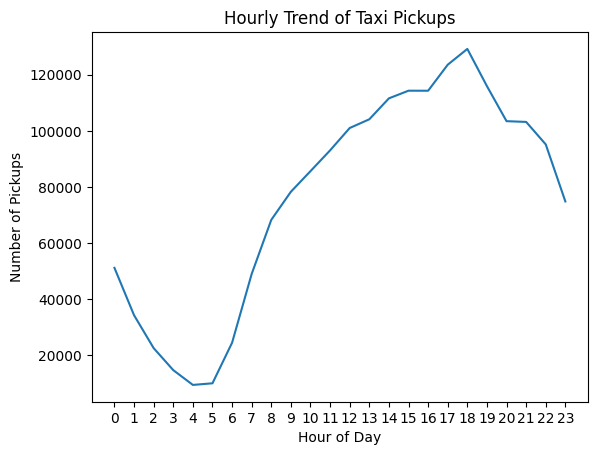

In [91]:
# Find and show the hourly trends in taxi pickups
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
hourly_pickups = (
    df.groupby('pickup_hour')
      .size()
      .reset_index(name='pickup_count')
)

plt.figure()
plt.plot(hourly_pickups['pickup_hour'], hourly_pickups['pickup_count'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Hourly Trend of Taxi Pickups')
plt.xticks(range(0, 24))
plt.show()


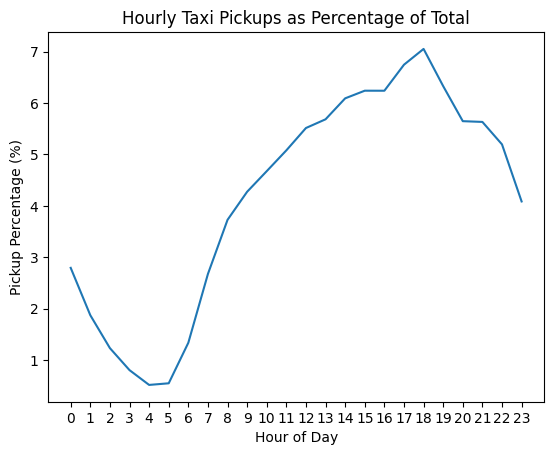

In [92]:
hourly_pct = (
    df.groupby('pickup_hour')
      .size()
      .reset_index(name='pickup_count')
)

hourly_pct['pickup_percentage'] = (
    hourly_pct['pickup_count'] / hourly_pct['pickup_count'].sum()
) * 100
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hourly_pct['pickup_hour'], hourly_pct['pickup_percentage'])
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Percentage (%)')
plt.title('Hourly Taxi Pickups as Percentage of Total')
plt.xticks(range(0, 24))
plt.show()


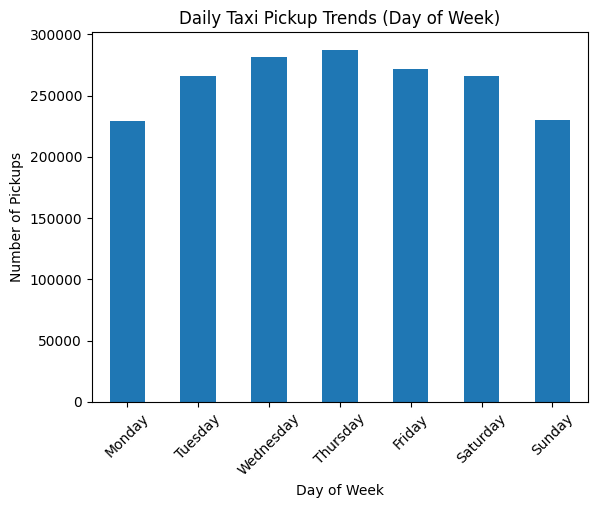

In [93]:
# Find and show the daily trends in taxi pickups (days of the week)
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()
day_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
]
daily_trends = (
    df.groupby('day_of_week')
      .size()
      .reindex(day_order)
)
daily_trends
daily_trends_pct = (daily_trends / daily_trends.sum() * 100).round(2)
daily_trends_pct
import matplotlib.pyplot as plt

daily_trends.plot(kind='bar')
plt.title('Daily Taxi Pickup Trends (Day of Week)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()



In [94]:
daily_trends.sum() == df.shape[0]


np.True_

In [95]:
(daily_trends / daily_trends.sum() * 100).round(2)


,0
day_of_week,
Monday,12.50
Tuesday,14.52
Wednesday,15.37
Thursday,15.69
Friday,14.83
Saturday,14.52
Sunday,12.57


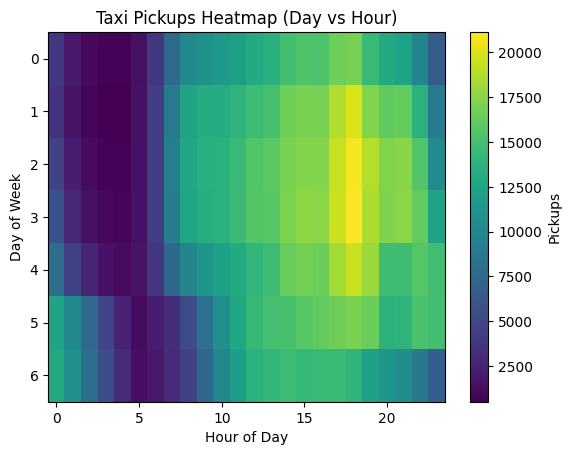

In [96]:
heatmap_data = (
    df.groupby([
        df['tpep_pickup_datetime'].dt.day_name(),
        df['tpep_pickup_datetime'].dt.hour
    ])
    .size()
    .unstack()
)

heatmap_data = heatmap_data.reindex(day_order)

import matplotlib.pyplot as plt
plt.imshow(heatmap_data, aspect='auto')
plt.colorbar(label='Pickups')
plt.title('Taxi Pickups Heatmap (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

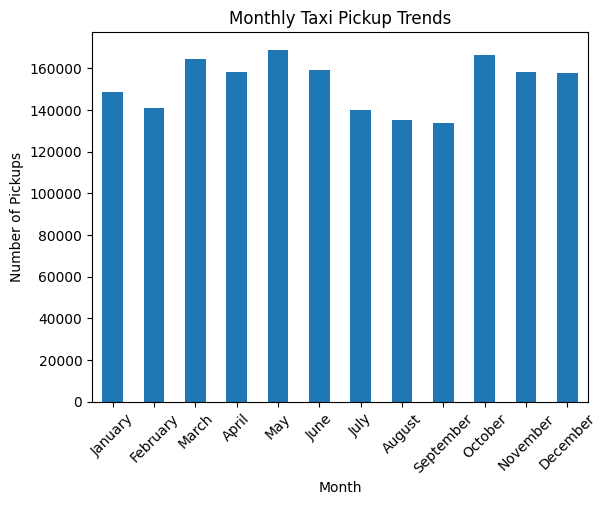

In [97]:
# Show the monthly trends in pickups
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_trends = (
    df.groupby('pickup_month')
      .size()
      .reindex(month_order)
)
monthly_trends
import matplotlib.pyplot as plt

monthly_trends.plot(kind='bar')
plt.title('Monthly Taxi Pickup Trends')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [98]:
# Analyse the above parameters
cols_to_check = [
    'fare_amount',
    'tip_amount',
    'total_amount',
    'trip_distance'
]

summary_zero_negative = {}

for col in cols_to_check:
    summary_zero_negative[col] = {
        'zero_count': (df[col] == 0).sum(),
        'negative_count': (df[col] < 0).sum()
    }

summary_zero_negative


{'fare_amount': {'zero_count': np.int64(501), 'negative_count': np.int64(0)},
 'tip_amount': {'zero_count': np.int64(410194), 'negative_count': np.int64(0)},
 'total_amount': {'zero_count': np.int64(255), 'negative_count': np.int64(0)},
 'trip_distance': {'zero_count': np.int64(22946),
  'negative_count': np.int64(0)}}

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

Yes, creating a separate copy DataFrame without zero values can be beneficial, if values like tip_amount = zero is not considered as it is a valid value.

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [99]:
#Keep zero-distance trips when the zone id is the same
valid_zero_distance = df[
    (df['trip_distance'] == 0) &
    (df['PULocationID'] == df['DOLocationID'])
]
#Remove zero distance trips only if they are inconsistent
df = df[
    ~(
        (df['trip_distance'] == 0) &
        (df['PULocationID'] != df['DOLocationID'])
    )
].reset_index(drop=True)

In [100]:
# Create a df with non zero entries for the selected parameters.
cols_non_zero = [
    'fare_amount',
    'total_amount',
    'trip_distance'
]

df_non_zero = df[
    (df['fare_amount'] > 0) &
    (df['total_amount'] > 0) &
    (df['trip_distance'] > 0)
].copy()
df_non_zero[cols_non_zero].min()


,0
fare_amount,0.01
total_amount,1.01
trip_distance,0.01


In [ ]:
df.shape, df_non_zero.shape


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [102]:
# Group data by month and analyse monthly revenue

df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_revenue = (
    df.groupby('pickup_month')['total_amount']
      .sum()
      .reindex(month_order)
)
monthly_revenue


,total_amount
pickup_month,
January,4036284.54
February,3812565.28
March,4599979.11
April,4522846.22
May,4924111.33
June,4636894.32
July,4033699.91
August,3931737.84
September,4153578.14


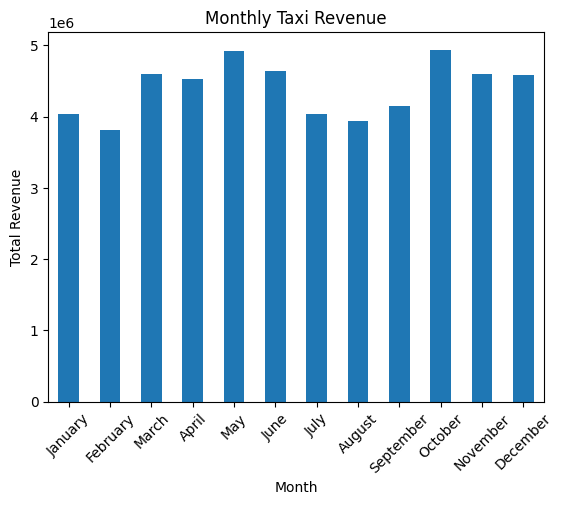

In [103]:
monthly_revenue_df = (
    monthly_revenue
    .reset_index()
    .rename(columns={'pickup_month': 'Month', 'total_amount': 'Total_Revenue'})
)

monthly_revenue_df
import matplotlib.pyplot as plt

monthly_revenue.plot(kind='bar')
plt.title('Monthly Taxi Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()


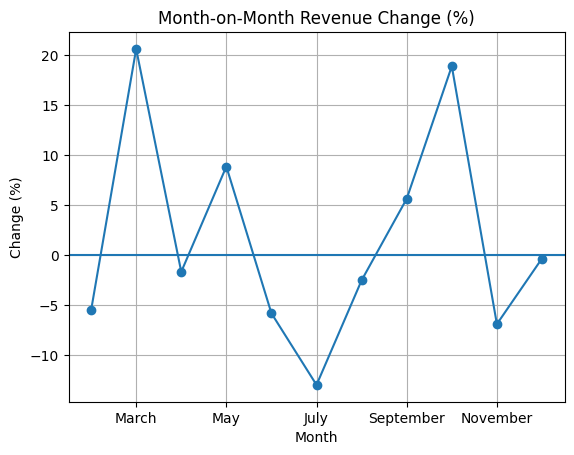

In [104]:
mom_change = monthly_revenue.pct_change() * 100

mom_change.plot(kind='line', marker='o')
plt.title('Month-on-Month Revenue Change (%)')
plt.xlabel('Month')
plt.ylabel('Change (%)')
plt.axhline(0)
plt.grid(True)
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [105]:
# Calculate proportion of each quarter
df['quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q').astype(str)
quarterly_revenue = df.groupby('quarter')['total_amount'].sum()
quarterly_revenue_proportion = (
    quarterly_revenue / quarterly_revenue.sum() * 100
).round(2)

quarterly_revenue_proportion



,total_amount
quarter,
2022Q4,0.00
2023Q1,23.59
2023Q2,26.69
2023Q3,22.97
2023Q4,26.76


In [ ]:
quarterly_revenue_summary = (
    df.groupby('quarter')['total_amount']
      .sum()
      .reset_index()
      .rename(columns={'total_amount': 'Total_Revenue'})
)

quarterly_revenue_summary['Revenue_Proportion (%)'] = (
    quarterly_revenue_summary['Total_Revenue'] /
    quarterly_revenue_summary['Total_Revenue'].sum() * 100
).round(2)

quarterly_revenue_summary

In [107]:
#Recompute the revenue only for year 2023
# Filter only 2023 quarters
quarterly_2023 = quarterly_revenue_summary[
    quarterly_revenue_summary['quarter'].str.startswith('2023')
].copy()

# Recompute proportions
quarterly_2023['Revenue_Proportion (%)'] = (
    quarterly_2023['Total_Revenue'] /
    quarterly_2023['Total_Revenue'].sum() * 100
).round(2)

quarterly_2023


,quarter,Total_Revenue,Revenue_Proportion (%)
1,2023Q1,12448828.93,23.59
2,2023Q2,14083851.87,26.69
3,2023Q3,12119015.89,22.97
4,2023Q4,14119657.19,26.76


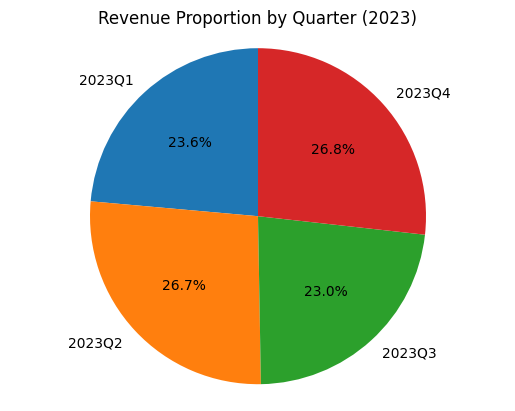

In [108]:
import matplotlib.pyplot as plt

# Data for pie chart
labels = quarterly_2023['quarter']
sizes = quarterly_2023['Revenue_Proportion (%)']

plt.figure()
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Revenue Proportion by Quarter (2023)')
plt.axis('equal')  # Ensures pie is circular
plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

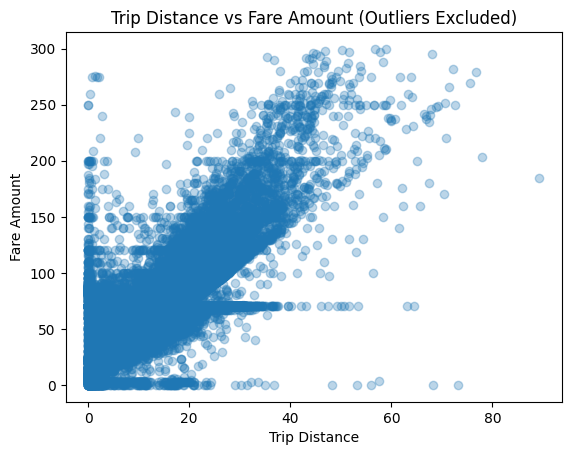

In [109]:
# Show how trip fare is affected by distance

df_dist_fare = df[df['trip_distance'] > 0].copy()
#Remove extreme outliers for visualization
df_plot = df_dist_fare[
    (df_dist_fare['trip_distance'] < 100) &
    (df_dist_fare['fare_amount'] < 300)
]

plt.figure()
plt.scatter(
    df_plot['trip_distance'],
    df_plot['fare_amount'],
    alpha=0.3
)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Trip Distance vs Fare Amount (Outliers Excluded)')
plt.show()




In [ ]:
#Most NYC taxi trips fall within:
#trip_distance ≤ 50 miles
# fare_amount ≤ 200 dollar
plt.figure()
plt.scatter(
    df_dist_fare['trip_distance'],
    df_dist_fare['fare_amount'],
    alpha=0.3
)
plt.xlim(0, 50)
plt.ylim(0, 200)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount (Zoomed View)')
plt.show()


In [ ]:
plt.figure()
plt.scatter(
    df_dist_fare['trip_distance'],
    df_dist_fare['fare_amount'],
    alpha=0.2
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Fare Amount (log scale)')
plt.title('Trip Distance vs Fare Amount (Log-Log Scale)')
plt.show()


In [ ]:
#Finding the correlation by not considering the outliers
df_corr_with_outliers = df_dist_fare['trip_distance'].corr(df_dist_fare['fare_amount'])
print("Unfiltered Pearson r = " , round(df_corr_with_outliers,2))

df_corr_without_outliers = df[
    (df['trip_distance'] > 0) &
    (df['trip_distance'] < 50) &
    (df['fare_amount'] > 0) &
    (df['fare_amount'] < 200)
]

print("Filtered Pearson r ≈ ", round(df_corr_without_outliers['trip_distance'].corr(df_corr_without_outliers['fare_amount']),2))


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [ ]:
# Show relationship between fare and trip duration

df_fare_duration = df[
    (df['trip_duration_minutes'] > 0) &
    (df['trip_duration_minutes'] < 300) &   # cap at 5 hours for visualization
    (df['fare_amount'] > 0) &
    (df['fare_amount'] < 300)
].copy()
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    df_fare_duration['trip_duration_minutes'],
    df_fare_duration['fare_amount'],
    alpha=0.3
)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount')
plt.title('Relationship between Trip Duration and Fare Amount')
plt.show()





In [114]:
corr_duration_fare = df_fare_duration['trip_duration_minutes'].corr(
    df_fare_duration['fare_amount']
)

round(corr_duration_fare, 2)


np.float64(0.82)

In [ ]:
# Show relationship between fare and number of passengers
#create a valid list of fares and passengers
df_pass_fare = df[
    (df['passenger_count'] >= 1) &
    (df['passenger_count'] <= 6) &
    (df['fare_amount'] > 0)
].copy()

df_plot = df_pass_fare[df_pass_fare['fare_amount'] < 300]

plt.figure()
df_plot.boxplot(
    column='fare_amount',
    by='passenger_count'
)
plt.title('Fare Amount by Number of Passengers (Outliers Removed)')
plt.suptitle('')
plt.xlabel('Number of Passengers')
plt.ylabel('Fare Amount')
plt.show()



In [ ]:
df_fare_pass = df[
    (df['passenger_count'] >= 1) &
    (df['passenger_count'] <= 6) &
    (df['fare_amount'] > 0)
]

pearson_corr = df_fare_pass['fare_amount'].corr(df_fare_pass['passenger_count'])
round(pearson_corr, 2)



In [ ]:
# Show relationship between tip and trip distance
df_tip_dist = df[
    (df['trip_distance'] > 0) &
    (df['trip_distance'] < 50) &     # realistic range
    (df['tip_amount'] >= 0) &
    (df['tip_amount'] < 200)
].copy()

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    df_tip_dist['trip_distance'],
    df_tip_dist['tip_amount'],
    alpha=0.3
)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount')
plt.title('Relationship between Trip Distance and Tip Amount')
plt.show()


In [ ]:
corr_tip_dist = df_tip_dist['trip_distance'].corr(df_tip_dist['tip_amount'])
round(corr_tip_dist, 2)


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [ ]:
# Analyse the distribution of different payment types (payment_type).

payment_dist = (
    df['payment_type']
    .value_counts()
    .rename(index={
        1: 'Credit Card',
        2: 'Cash',
        3: 'No Charge',
        4: 'Dispute'
    })
)

payment_dist



In [ ]:
payment_pct = (payment_dist / payment_dist.sum() * 100).round(2)
payment_pct


In [ ]:
import matplotlib.pyplot as plt

payment_pct.plot(kind='bar')
plt.title('Percentage Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Percentage of Trips (%)')
plt.xticks(rotation=45)
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [123]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('/content/drive/MyDrive/Datasets and Dictionary/taxi_zones/taxi_zones.shp')
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [ ]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
# Merge zones and trip records using locationID and PULocationID
zones['LocationID'] = zones['LocationID'].astype(int)
df['PULocationID'] = df['PULocationID'].astype(int)

In [ ]:
df_merged = df.merge(
    zones,
    how='left',
    left_on='PULocationID',
    right_on='LocationID'
)
df_merged[['PULocationID', 'LocationID', 'zone', 'borough']].head()

In [ ]:
#missing values
df_merged['zone'].isna().sum()

In [ ]:
#clean up redundant data
df_merged.drop(columns=['LocationID'], inplace=True)

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips
trips_per_location = (
    df_merged.groupby('PULocationID')
      .size()
      .reset_index(name='Total_Trips')
)

trips_per_location.head()


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame

zones_with_trips = zones.merge(
    trips_per_location,
    how='left',
    left_on='LocationID',
    right_on='PULocationID'
)
zones_with_trips[['LocationID', 'zone', 'borough', 'Total_Trips']].head()



The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [ ]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))




# Plot the map and display it
zones_with_trips.plot(
    column='Total_Trips',
    ax=ax,
    legend=True,
    cmap='OrRd',
    linewidth=0.3,
    edgecolor='black'
)

ax.set_title('Taxi Trips by Pickup Zone', fontsize=14)
ax.axis('off')

plt.show()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones_with_trips.plot(
    column='Total_Trips',
    ax=ax,
    legend=True,
    cmap='OrRd',
    scheme='quantiles',
    k=5
)
ax.set_title('Taxi Trips by Pickup Zone', fontsize=14)
ax.axis('off')
plt.show()

In [ ]:
# can you try displaying the zones DF sorted by the number of trips?

zones_sorted = zones_with_trips.sort_values(
    by='Total_Trips',
    ascending=False
)
#Top 10 busiest pickup zones
zones_sorted[['LocationID', 'zone', 'borough', 'Total_Trips']].head(10)



In [134]:
#Least busy zones
zones_sorted[['LocationID', 'zone', 'borough', 'Total_Trips']].tail(10)

,LocationID,zone,borough,Total_Trips
171,172,New Dorp/Midland Beach,Staten Island,1.0
220,221,Stapleton,Staten Island,1.0
29,30,Broad Channel,Queens,NaN
98,99,Freshkills Park,Staten Island,NaN
102,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,NaN
103,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,NaN
104,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,NaN
109,110,Great Kills Park,Staten Island,NaN
175,176,Oakwood,Staten Island,NaN
244,245,West Brighton,Staten Island,NaN


In [ ]:
#Filter zones with zero trips
zones_non_null = zones_with_trips[zones_with_trips['Total_Trips'].notna()]

zones_non_null.sort_values('Total_Trips').head(10)



In [ ]:
zones_non_null[['LocationID', 'zone', 'borough', 'Total_Trips']].tail(10).sort_values('Total_Trips')

In [ ]:
#zones with 0 or null trips
zones_null = zones_with_trips[zones_with_trips['Total_Trips'].isna()]
zones_null

In [ ]:
# Drop geometry for plotting
zones_ranked = (
    zones_with_trips
    .drop(columns='geometry')
    .sort_values('Total_Trips', ascending=False)
)
import matplotlib.pyplot as plt

top_n = 15
top_zones = zones_ranked.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(
    top_zones['zone'],
    top_zones['Total_Trips']
)
plt.gca().invert_yaxis()  # Highest at top
plt.xlabel('Total Number of Trips')
plt.ylabel('Zone')
plt.title(f'Top {top_n} Pickup Zones by Number of Trips')
plt.show()


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:
# Find routes which have the slowest speeds at different times of the day
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour

#Clean the data so that only valid routes are considered
df_clean = df[
    (~df['anomaly_flag']) &                     # logical / temporal errors
    (df['trip_distance'] > 0) &
    (df['trip_duration_minutes'] > 0) &
    (df['total_amount'] > 0)
].copy()

df_clean[['trip_distance', 'trip_duration_minutes', 'total_amount']].min()



In [ ]:
route_hour_stats = (
    df_clean
    .groupby(['PULocationID', 'DOLocationID', 'hour'])
    .agg(
        avg_distance=('trip_distance', 'mean'),
        avg_duration=('trip_duration_minutes', 'mean'),
        trip_count=('trip_distance', 'size')
    )
    .reset_index()
)

# speed in miles per minute
route_hour_stats['avg_speed_miles_per_min'] = (
    route_hour_stats['avg_distance'] / route_hour_stats['avg_duration']
)

# convert to miles per hour
route_hour_stats['avg_speed_mph'] = (
    route_hour_stats['avg_speed_miles_per_min'] * 60
)

# identify slow routes (bottom 10%)
slow_routes = route_hour_stats[
    route_hour_stats['avg_speed_mph'] <
    route_hour_stats['avg_speed_mph'].quantile(0.10)
].sort_values('avg_speed_mph')

slow_routes.head(10)


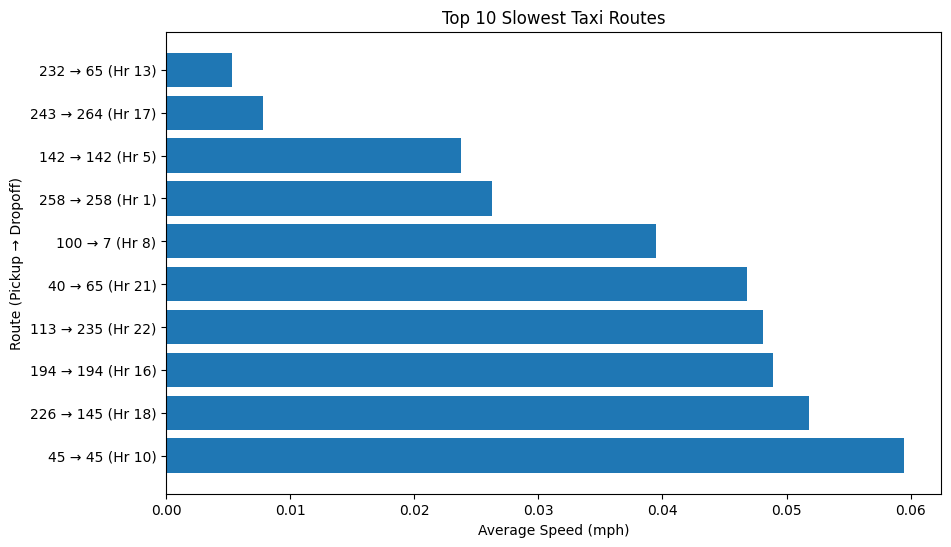

In [141]:
import matplotlib.pyplot as plt
slow_routes['route'] = (
    slow_routes['PULocationID'].astype(str) +
    ' → ' +
    slow_routes['DOLocationID'].astype(str)
)


slow_routes_top10 = slow_routes.head(10)

slow_routes_top10['route_hour'] = (
    slow_routes_top10['route'] +
    ' (Hr ' +
    slow_routes_top10['hour'].astype(str) +
    ')'
)


plt.figure(figsize=(10, 6))
plt.barh(
    slow_routes_top10['route_hour'],
    slow_routes_top10['avg_speed_mph']
)

plt.xlabel('Average Speed (mph)')
plt.ylabel('Route (Pickup → Dropoff)')
plt.title('Top 10 Slowest Taxi Routes')
plt.gca().invert_yaxis()   # Slowest on top
plt.show()


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [142]:
# Visualise the number of trips per hour and find the busiest hour
hourly_trips = (
    df_clean.groupby('hour')
      .size()
      .reset_index(name='Total_Trips')
)


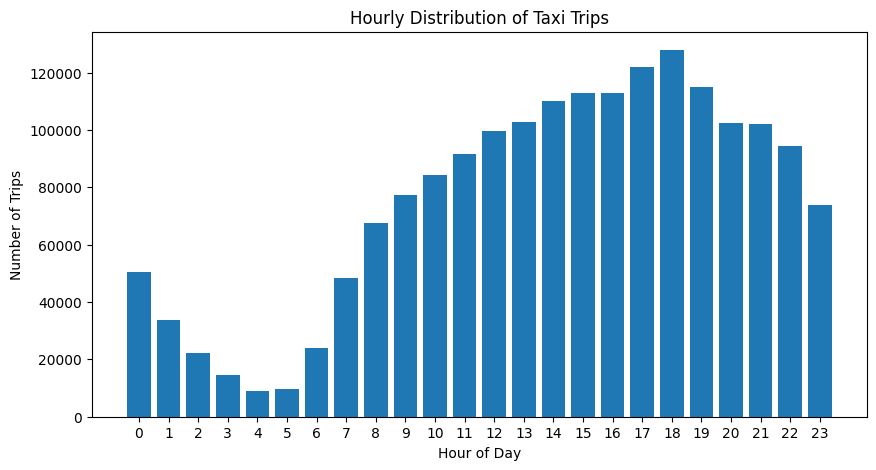

In [143]:
plt.figure(figsize=(10, 5))
plt.bar(hourly_trips['hour'], hourly_trips['Total_Trips'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Hourly Distribution of Taxi Trips')
plt.xticks(range(0, 24))
plt.show()


In [144]:
busiest_hour = hourly_trips.loc[
    hourly_trips['Total_Trips'].idxmax()
]
busiest_hour_num = busiest_hour['hour']
busiest_hour_trips = busiest_hour['Total_Trips']

print(
    f"Busiest hour: {busiest_hour_num}:00 – {busiest_hour_num + 1}:00 "
    f"with {busiest_hour_trips:,} trips"
)



Busiest hour: 18:00 – 19:00 with 127,873 trips


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [145]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sampling_fraction = 0.05
scaling_factor = 1 / sampling_fraction   # = 20

hourly_trips['Estimated_Total_Trips'] = (
    hourly_trips['Total_Trips'] * scaling_factor
).astype(int)

top_5_hours = (
    hourly_trips
    .sort_values('Estimated_Total_Trips', ascending=False)
    .head(5)
)

top_5_hours
top_5_hours.assign(
    Hour_Range=lambda x: x['hour'].astype(str) + ':00–' + (x['hour']+1).astype(str) + ':00'
)[['Hour_Range', 'Estimated_Total_Trips']]



,Hour_Range,Estimated_Total_Trips
18,18:00–19:00,2557460
17,17:00–18:00,2441360
19,19:00–20:00,2296620
15,15:00–16:00,2256900
16,16:00–17:00,2254740


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [146]:
# Compare traffic trends for the week days and weekends
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
# Monday=0, Sunday=6

df['day_type'] = df['day_of_week'].apply(
    lambda x: 'Weekday' if x < 5 else 'Weekend'
)
#Compute hourly traffic for weekdays vs weekends
hourly_daytype_trips = (
    df.groupby(['day_type', 'hour'])
      .size()
      .reset_index(name='Total_Trips')
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for day_type in ['Weekday', 'Weekend']:
    subset = hourly_daytype_trips[
        hourly_daytype_trips['day_type'] == day_type
    ]
    plt.plot(subset['hour'], subset['Total_Trips'], marker='o', label=day_type)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Hourly Traffic Trends: Weekdays vs Weekends')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [148]:
# Find top 10 pickup and dropoff zones
hourly_pickups = (
    df.groupby(['PULocationID', 'hour'])
      .size()
      .reset_index(name='Pickup_Trips')
)
top10_pickup_zones = (
    hourly_pickups.groupby('PULocationID')['Pickup_Trips']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)



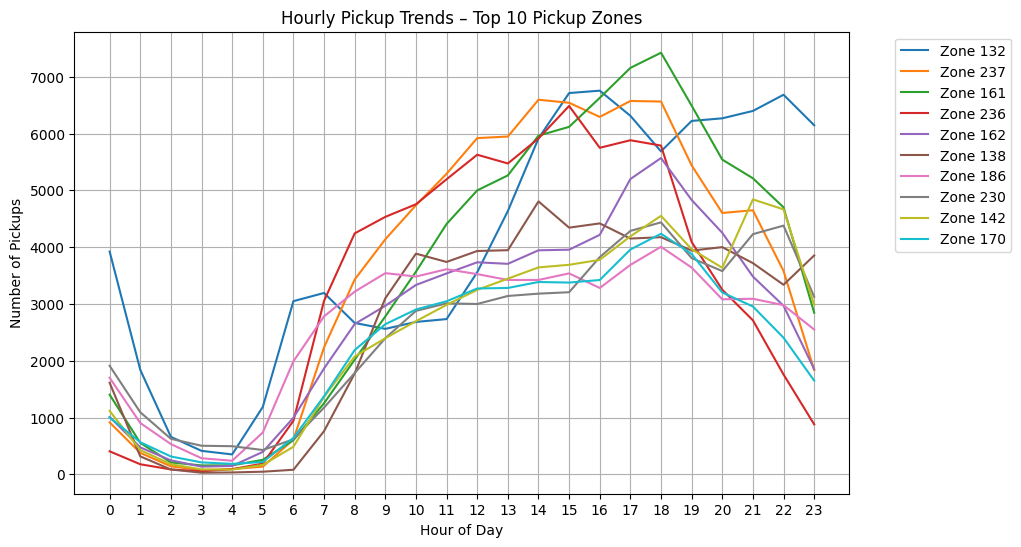

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for zone in top10_pickup_zones:
    zone_data = hourly_pickups[hourly_pickups['PULocationID'] == zone]
    plt.plot(zone_data['hour'], zone_data['Pickup_Trips'], label=f'Zone {zone}')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Hourly Pickup Trends – Top 10 Pickup Zones')
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [150]:
hourly_dropoffs = (
    df.groupby(['DOLocationID', 'hour'])
      .size()
      .reset_index(name='Dropoff_Trips')
)
top10_dropoff_zones = (
    hourly_dropoffs.groupby('DOLocationID')['Dropoff_Trips']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)


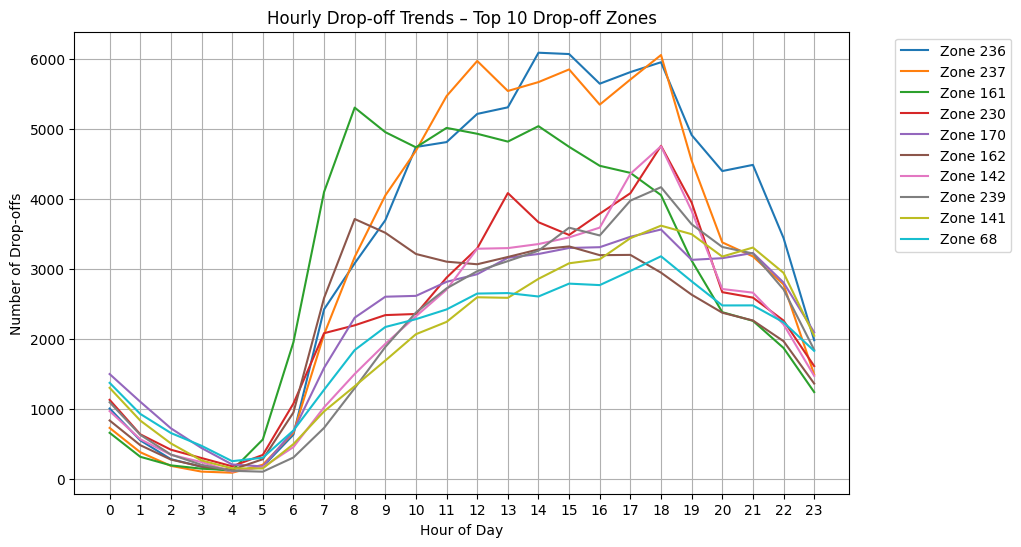

In [151]:
plt.figure(figsize=(10, 6))

for zone in top10_dropoff_zones:
    zone_data = hourly_dropoffs[hourly_dropoffs['DOLocationID'] == zone]
    plt.plot(zone_data['hour'], zone_data['Dropoff_Trips'], label=f'Zone {zone}')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Drop-offs')
plt.title('Hourly Drop-off Trends – Top 10 Drop-off Zones')
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [152]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Total pickups per zone
pickups = (
    df.groupby('PULocationID')
      .size()
      .reset_index(name='pickup_count')
)

# Total drop-offs per zone
dropoffs = (
    df.groupby('DOLocationID')
      .size()
      .reset_index(name='dropoff_count')
)


In [153]:
zone_flow = pickups.merge(
    dropoffs,
    how='outer',
    left_on='PULocationID',
    right_on='DOLocationID'
)
#create single LocationID
zone_flow['LocationID'] = zone_flow['PULocationID'].combine_first(
    zone_flow['DOLocationID']
)
#Handle any missing values
zone_flow['pickup_count'] = zone_flow['pickup_count'].fillna(0)
zone_flow['dropoff_count'] = zone_flow['dropoff_count'].fillna(0)


In [154]:
#Calculate pickup- dropoff ration, avoiding dividing by zero
zone_flow['pickup_dropoff_ratio'] = (
    zone_flow['pickup_count'] /
    zone_flow['dropoff_count'].replace(0, pd.NA)
)
zone_flow_final = zone_flow[
    ['LocationID', 'pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']
]


In [155]:
#Highest pickup/dropoff ratios
top_10_high = (
    zone_flow_final
    .dropna(subset=['pickup_dropoff_ratio'])
    .sort_values('pickup_dropoff_ratio', ascending=False)
    .head(10)
)

top_10_high


,LocationID,pickup_count,dropoff_count,pickup_dropoff_ratio
69,70.0,8302.0,976.0,8.506148
127,132.0,96546.0,20914.0,4.616334
133,138.0,64077.0,22170.0,2.890257
181,186.0,63236.0,40009.0,1.580544
42,43.0,30661.0,22298.0,1.375056
109,114.0,24059.0,17507.0,1.37425
244,249.0,40324.0,30387.0,1.327015
157,162.0,65457.0,52102.0,1.256324
156,161.0,85701.0,71445.0,1.199538
99,100.0,30087.0,25261.0,1.191045


In [156]:
#Lowest pickup/dropoff ratios
top_10_low = (
    zone_flow_final
    .dropna(subset=['pickup_dropoff_ratio'])
    .sort_values('pickup_dropoff_ratio', ascending=True)
    .head(10)
)

top_10_low


,LocationID,pickup_count,dropoff_count,pickup_dropoff_ratio
171,176.0,0.0,12.0,0.0
98,99.0,0.0,3.0,0.0
29,30.0,0.0,18.0,0.0
240,245.0,0.0,30.0,0.0
26,27.0,1.0,38.0,0.026316
216,221.0,1.0,34.0,0.029412
252,257.0,23.0,751.0,0.030626
0,1.0,200.0,5312.0,0.037651
193,198.0,44.0,981.0,0.044852
110,115.0,1.0,22.0,0.045455


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [157]:
# Duringm night hours (11pm to 5a) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_hours = [23, 0, 1, 2, 3, 4, 5]
df_night = df[df['hour'].isin(night_hours)].copy()

night_pickups = (
    df_night.groupby('PULocationID')
    .size()
    .reset_index(name='Night_Pickups')
    .sort_values('Night_Pickups', ascending=False)
    .head(10)
)

night_pickups


,PULocationID,Night_Pickups
71,79,15503
114,132,14517
221,249,12445
42,48,10432
130,148,9615
99,114,8737
203,230,8180
162,186,6943
144,164,6130
60,68,6016


In [158]:
night_dropoffs = (
    df_night.groupby('DOLocationID')
    .size()
    .reset_index(name='Night_Dropoffs')
    .sort_values('Night_Dropoffs', ascending=False)
    .head(10)
)

night_dropoffs


,DOLocationID,Night_Dropoffs
77,79,8295
46,48,6864
164,170,6253
66,68,5824
102,107,5734
135,141,5259
255,263,4968
241,249,4935
222,230,4624
221,229,4371


In [159]:
night_pickups_named = night_pickups.merge(
    zones[['LocationID', 'zone', 'borough']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

night_dropoffs_named = night_dropoffs.merge(
    zones[['LocationID', 'zone', 'borough']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
)
top10_night_pickup_zones = night_pickups_named[
    ['zone', 'borough', 'Night_Pickups']
]

from IPython.display import display, Markdown

display(Markdown("**Top 10 Night Pickup Zones**"))


top10_night_pickup_zones.sort_values(
    'Night_Pickups', ascending=False
).reset_index(drop=True)





**Top 10 Night Pickup Zones**

,zone,borough,Night_Pickups
0,East Village,Manhattan,15503
1,JFK Airport,Queens,14517
2,West Village,Manhattan,12445
3,Clinton East,Manhattan,10432
4,Lower East Side,Manhattan,9615
5,Greenwich Village South,Manhattan,8737
6,Times Sq/Theatre District,Manhattan,8180
7,Penn Station/Madison Sq West,Manhattan,6943
8,Midtown South,Manhattan,6130
9,East Chelsea,Manhattan,6016


In [160]:
from IPython.display import display, Markdown

display(Markdown("**Top 10 Night Dropoff Zones**"))


top10_night_dropoff_zones = night_dropoffs_named[
    ['zone', 'borough', 'Night_Dropoffs']
]

top10_night_dropoff_zones.sort_values(
    'Night_Dropoffs', ascending=False
).reset_index(drop=True)



**Top 10 Night Dropoff Zones**

,zone,borough,Night_Dropoffs
0,East Village,Manhattan,8295
1,Clinton East,Manhattan,6864
2,Murray Hill,Manhattan,6253
3,East Chelsea,Manhattan,5824
4,Gramercy,Manhattan,5734
5,Lenox Hill West,Manhattan,5259
6,Yorkville West,Manhattan,4968
7,West Village,Manhattan,4935
8,Times Sq/Theatre District,Manhattan,4624
9,Sutton Place/Turtle Bay North,Manhattan,4371


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [161]:
# Filter for night hours (11 PM to 5 AM)
night_hours = [23, 0, 1, 2, 3, 4, 5]

df['time_period'] = df['hour'].apply(
    lambda x: 'Nighttime' if x in night_hours else 'Daytime'
)
revenue_by_period = (
    df.groupby('time_period')['total_amount']
      .sum()
      .reset_index(name='Total_Revenue')
)
total_revenue = revenue_by_period['Total_Revenue'].sum()

revenue_by_period['Revenue_Share_%'] = (
    revenue_by_period['Total_Revenue'] / total_revenue * 100
).round(2)

revenue_by_period



,time_period,Total_Revenue,Revenue_Share_%
0,Daytime,46406220.20,87.94
1,Nighttime,6365147.18,12.06


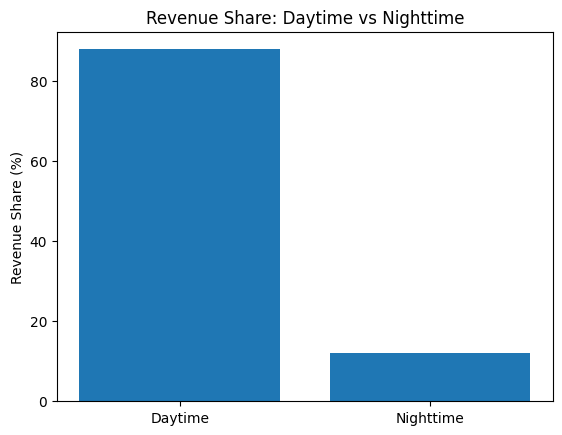

In [162]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    revenue_by_period['time_period'],
    revenue_by_period['Revenue_Share_%']
)
plt.ylabel('Revenue Share (%)')
plt.title('Revenue Share: Daytime vs Nighttime')
plt.show()


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [163]:
# Analyse the fare per mile per passenger for different passenger counts
df_fare_mile = df[
    (df['passenger_count'] >= 1) &
    (df['passenger_count'] <= 6) &
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0)
].copy()

df_fare_mile['fare_per_mile'] = (
    df_fare_mile['fare_amount'] / df_fare_mile['trip_distance']
)
#Average fare per mile by passenger count
avg_fare_per_mile = (
    df_fare_mile
    .groupby('passenger_count')['fare_per_mile']
    .mean()
    .reset_index(name='avg_fare_per_mile')
)

avg_fare_per_mile['fare_per_mile_per_passenger'] = (
    avg_fare_per_mile['avg_fare_per_mile'] /
    avg_fare_per_mile['passenger_count']
)
avg_fare_per_mile.round(2)




,passenger_count,avg_fare_per_mile,fare_per_mile_per_passenger
0,1.0,11.01,11.01
1,2.0,12.86,6.43
2,3.0,11.72,3.91
3,4.0,17.72,4.43
4,5.0,8.55,1.71
5,6.0,8.10,1.35


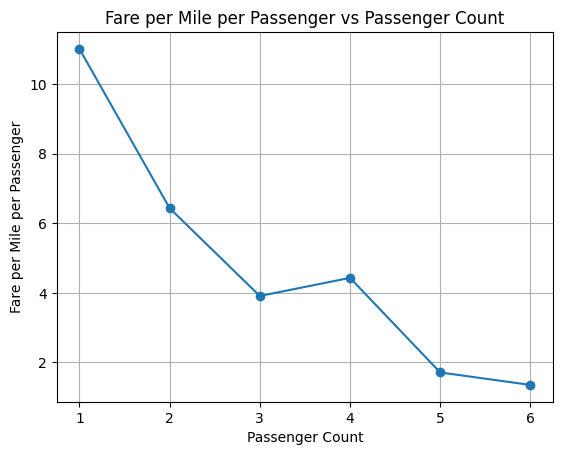

In [164]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    avg_fare_per_mile['passenger_count'],
    avg_fare_per_mile['fare_per_mile_per_passenger'],
    marker='o'
)
plt.xlabel('Passenger Count')
plt.ylabel('Fare per Mile per Passenger')
plt.title('Fare per Mile per Passenger vs Passenger Count')
plt.grid(True)
plt.show()


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [165]:
# Compare the average fare per mile for different days and for different times of the day
# Keep valid trips only
df_fpm = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0)
].copy()

df_fpm['fare_per_mile'] = df_fpm['fare_amount'] / df_fpm['trip_distance']

# Day of week
df_fpm['day_of_week'] = df_fpm['tpep_pickup_datetime'].dt.day_name()
avg_fpm_day = (
    df_fpm
    .groupby('day_of_week')['fare_per_mile']
    .mean()
    .reindex([
        'Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    .reset_index(name='avg_fare_per_mile')
    .round(2)
)

avg_fpm_day



,day_of_week,avg_fare_per_mile
0,Monday,10.99
1,Tuesday,12.17
2,Wednesday,11.11
3,Thursday,11.27
4,Friday,10.91
5,Saturday,10.92
6,Sunday,12.58


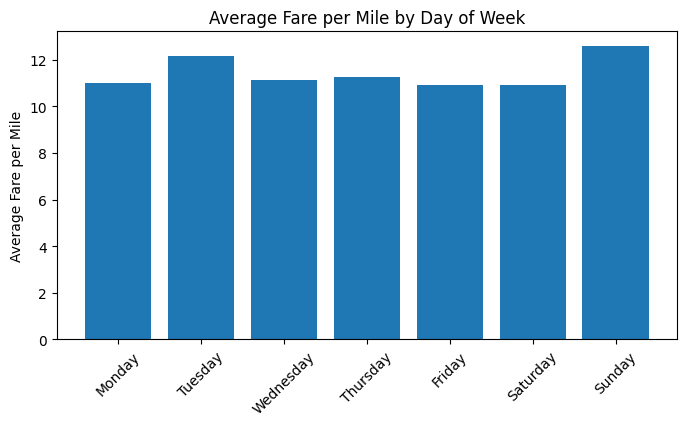

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(avg_fpm_day['day_of_week'], avg_fpm_day['avg_fare_per_mile'])
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Day of Week')
plt.xticks(rotation=45)
plt.show()


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [167]:
# Compare fare per mile for different vendors
df_fpm = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0)
].copy()

df_fpm['fare_per_mile'] = df_fpm['fare_amount'] / df_fpm['trip_distance']
avg_fpm_hour = (
    df_fpm
    .groupby('hour')['fare_per_mile']
    .mean()
    .reset_index(name='avg_fare_per_mile')
)

avg_fpm_hour.head()



,hour,avg_fare_per_mile
0,0,10.525939
1,1,11.266999
2,2,9.942036
3,3,10.870866
4,4,14.004000


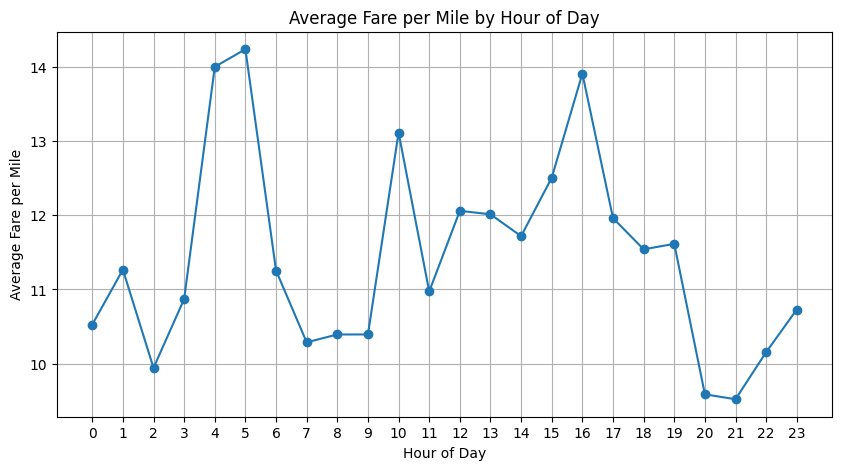

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(avg_fpm_hour['hour'], avg_fpm_hour['avg_fare_per_mile'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [169]:
df_vendor = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0)
].copy()

df_vendor['fare_per_mile'] = df_vendor['fare_amount'] / df_vendor['trip_distance']

# Defining distance tiers
def distance_tier(dist):
    if dist <= 2:
        return 'Up to 2 miles'
    elif dist <= 5:
        return '2–5 miles'
    else:
        return 'More than 5 miles'

df_vendor['distance_tier'] = df_vendor['trip_distance'].apply(distance_tier)

vendor_fare_tier = (
    df_vendor
    .groupby(['VendorID', 'distance_tier'])['fare_per_mile']
    .mean()
    .reset_index()
)
vendor_fare_pivot = vendor_fare_tier.pivot(
    index='VendorID',
    columns='distance_tier',
    values='fare_per_mile'
).round(2)

vendor_fare_pivot


distance_tier,2–5 miles,More than 5 miles,Up to 2 miles
VendorID,,,
1,6.38,4.43,10.67
2,6.55,4.50,17.94


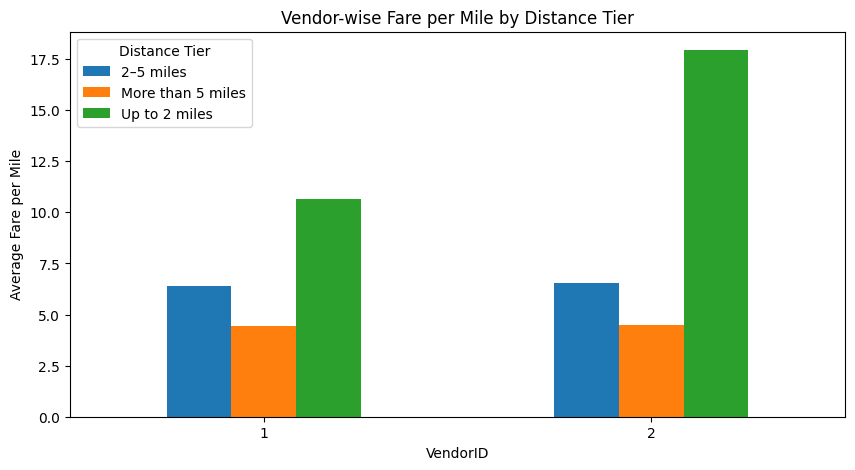

In [170]:
import matplotlib.pyplot as plt

vendor_fare_pivot.plot(kind='bar', figsize=(10, 5))
plt.ylabel('Average Fare per Mile')
plt.title('Vendor-wise Fare per Mile by Distance Tier')
plt.xticks(rotation=0)
plt.legend(title='Distance Tier')
plt.show()


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [171]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# Filter valid trips
df_tip = df[
    (df['fare_amount'] > 0) &
    (df['tip_amount'] >= 0) &
    (df['trip_distance'] > 0) &
    (df['passenger_count'] >= 1)
].copy()

# Tip percentage
df_tip['tip_percentage'] = (df_tip['tip_amount'] / df_tip['fare_amount']) * 100

def distance_tier(dist):
    if dist <= 2:
        return 'Up to 2 miles'
    elif dist <= 5:
        return '2–5 miles'
    else:
        return 'More than 5 miles'

df_tip['distance_tier'] = df_tip['trip_distance'].apply(distance_tier)

tip_by_distance = (
    df_tip
    .groupby('distance_tier')['tip_percentage']
    .mean()
    .reset_index()
    .round(2)
)

tip_by_distance



,distance_tier,tip_percentage
0,2–5 miles,18.77
1,More than 5 miles,17.64
2,Up to 2 miles,22.42


In [172]:
tip_by_passenger = (
    df_tip
    .groupby('passenger_count')['tip_percentage']
    .mean()
    .reset_index()
    .round(2)
)

tip_by_passenger


,passenger_count,tip_percentage
0,1.0,20.94
1,2.0,19.73
2,3.0,19.03
3,4.0,17.46
4,5.0,20.49
5,6.0,20.60


In [173]:
tip_by_hour = (
    df_tip
    .groupby('hour')['tip_percentage']
    .mean()
    .reset_index()
    .round(2)
)

tip_by_hour


,hour,tip_percentage
0,0,20.50
1,1,20.66
2,2,20.65
3,3,20.51
4,4,18.25
5,5,17.49
6,6,18.47
7,7,19.61
8,8,20.05
9,9,19.71


In [174]:
night_hours = [23, 0, 1, 2, 3, 4, 5]

df_tip['time_period'] = np.where(
    df_tip['hour'].isin(night_hours),
    'Nighttime',
    'Daytime'
)

tip_by_time_period = (
    df_tip
    .groupby('time_period')['tip_percentage']
    .mean()
    .reset_index()
    .round(2)
)

tip_by_time_period


,time_period,tip_percentage
0,Daytime,20.63
1,Nighttime,20.36


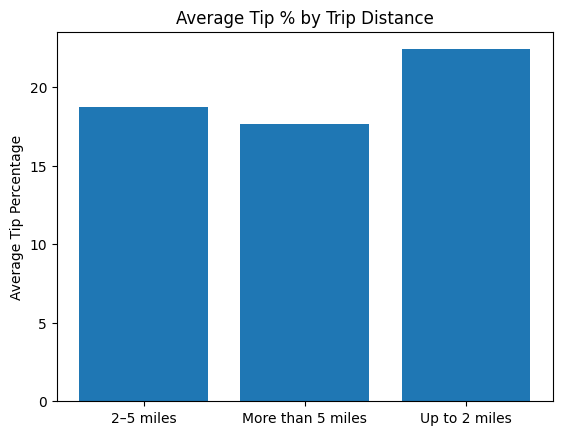

In [175]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(tip_by_distance['distance_tier'], tip_by_distance['tip_percentage'])
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip % by Trip Distance')
plt.show()


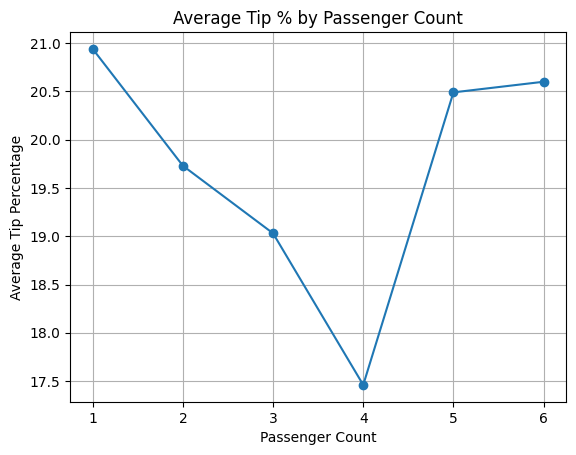

In [176]:
plt.figure()
plt.plot(
    tip_by_passenger['passenger_count'],
    tip_by_passenger['tip_percentage'],
    marker='o'
)
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip % by Passenger Count')
plt.grid(True)
plt.show()


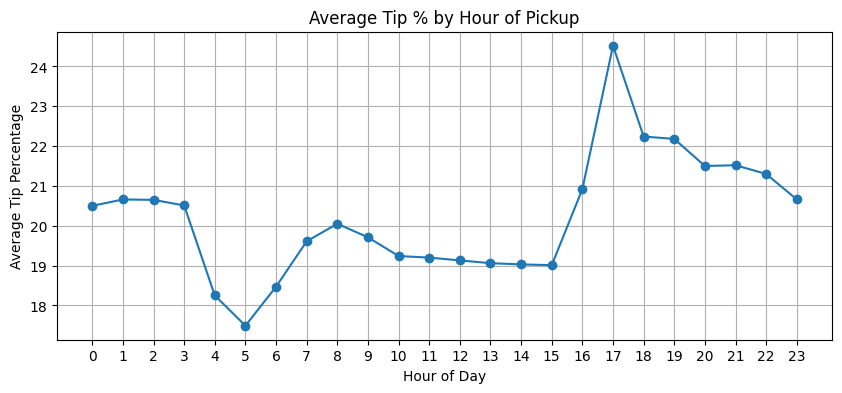

In [177]:
plt.figure(figsize=(10, 4))
plt.plot(tip_by_hour['hour'], tip_by_hour['tip_percentage'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip % by Hour of Pickup')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [178]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Create tip percentage (safety check)
df_tip['tip_percentage'] = (df_tip['tip_amount'] / df_tip['fare_amount']) * 100

# Define low-tip and high-tip trips
low_tip_trips = df_tip[df_tip['tip_percentage'] < 10]
high_tip_trips = df_tip[df_tip['tip_percentage'] > 25]

comparison_summary = pd.DataFrame({
    'Metric': [
        'Average Fare',
        'Average Trip Distance',
        'Average Trip Duration (min)',
        'Average Passenger Count',
        'Average Tip Percentage'
    ],
    'Low Tip (<10%)': [
        low_tip_trips['fare_amount'].mean(),
        low_tip_trips['trip_distance'].mean(),
        low_tip_trips['trip_duration_minutes'].mean(),
        low_tip_trips['passenger_count'].mean(),
        low_tip_trips['tip_percentage'].mean()
    ],
    'High Tip (>25%)': [
        high_tip_trips['fare_amount'].mean(),
        high_tip_trips['trip_distance'].mean(),
        high_tip_trips['trip_duration_minutes'].mean(),
        high_tip_trips['passenger_count'].mean(),
        high_tip_trips['tip_percentage'].mean()
    ]
}).round(2)

comparison_summary


,Metric,Low Tip (<10%),High Tip (>25%)
0,Average Fare,21.89,14.41
1,Average Trip Distance,4.17,2.34
2,Average Trip Duration (min),20.06,12.74
3,Average Passenger Count,1.43,1.36
4,Average Tip Percentage,1.08,32.54


In [179]:
payment_map = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

low_tip_trips['payment_method'] = low_tip_trips['payment_type'].map(payment_map)
high_tip_trips['payment_method'] = high_tip_trips['payment_type'].map(payment_map)
payment_comparison_named = pd.concat([
    low_tip_trips['payment_method']
        .value_counts(normalize=True)
        .rename('Low Tip (<10%)'),

    high_tip_trips['payment_method']
        .value_counts(normalize=True)
        .rename('High Tip (>25%)')
], axis=1).fillna(0).round(2)

payment_comparison_named



,Low Tip (<10%),High Tip (>25%)
payment_method,,
Cash,0.66,0.0
Credit Card,0.30,1.0
Dispute,0.03,0.0
No Charge,0.01,0.0


In [180]:
def hour_bucket(hour):
    if 0 <= hour < 5:
        return 'Late Night / Early Morning (12–5 AM)'
    elif 5 <= hour < 9:
        return 'Morning (5–9 AM)'
    elif 9 <= hour < 12:
        return 'Late Morning (9–12 PM)'
    elif 12 <= hour < 17:
        return 'Afternoon (12–5 PM)'
    elif 17 <= hour < 21:
        return 'Evening (5–9 PM)'
    else:
        return 'Night (9–12 AM)'

df_tip['time_of_day'] = df_tip['hour'].apply(hour_bucket)
low_tip_trips['time_of_day'] = low_tip_trips['hour'].apply(hour_bucket)
high_tip_trips['time_of_day'] = high_tip_trips['hour'].apply(hour_bucket)
time_comparison = pd.concat([
    low_tip_trips['time_of_day'].value_counts().rename('Low Tip (<10%)'),
    high_tip_trips['time_of_day'].value_counts().rename('High Tip (>25%)')
], axis=1).fillna(0)

time_comparison




,Low Tip (<10%),High Tip (>25%)
time_of_day,,
Afternoon (12–5 PM),152003,222668
Evening (5–9 PM),110292,235337
Late Morning (9–12 PM),70345,105649
Night (9–12 AM),61955,129160
Morning (5–9 AM),40502,61938
Late Night / Early Morning (12–5 AM),35989,58650


**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [181]:
# See how passenger count varies across hours and days

avg_passenger_hour = (
    df.groupby('hour')['passenger_count']
      .mean()
      .reset_index(name='avg_passenger_count')
)

avg_passenger_hour



,hour,avg_passenger_count
0,0,1.429336
1,1,1.433481
2,2,1.450327
3,3,1.455980
4,4,1.404713
5,5,1.299960
6,6,1.256433
7,7,1.277360
8,8,1.294488
9,9,1.317655


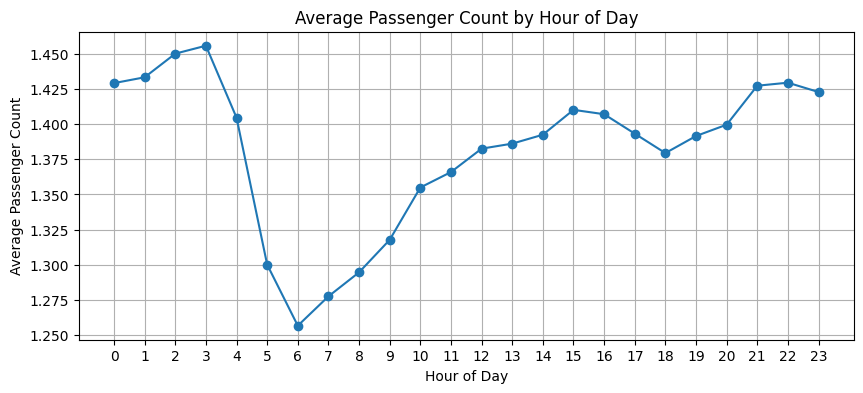

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(
    avg_passenger_hour['hour'],
    avg_passenger_hour['avg_passenger_count'],
    marker='o'
)
plt.xlabel('Hour of Day')
plt.ylabel('Average Passenger Count')
plt.title('Average Passenger Count by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


In [183]:
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

avg_passenger_day = (
    df.groupby('day_of_week')['passenger_count']
      .mean()
      .reindex([
          'Monday', 'Tuesday', 'Wednesday',
          'Thursday', 'Friday', 'Saturday', 'Sunday'
      ])
      .reset_index(name='avg_passenger_count')
)

avg_passenger_day


,day_of_week,avg_passenger_count
0,Monday,1.361709
1,Tuesday,1.333793
2,Wednesday,1.330331
3,Thursday,1.343707
4,Friday,1.400911
5,Saturday,1.480146
6,Sunday,1.464877


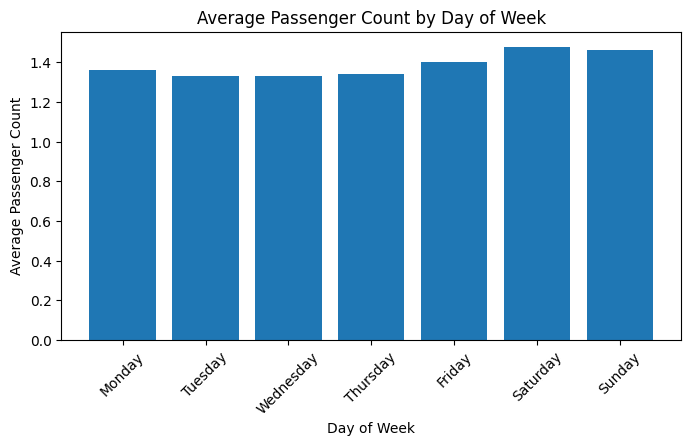

In [184]:
plt.figure(figsize=(8, 4))
plt.bar(
    avg_passenger_day['day_of_week'],
    avg_passenger_day['avg_passenger_count']
)
plt.xlabel('Day of Week')
plt.ylabel('Average Passenger Count')
plt.title('Average Passenger Count by Day of Week')
plt.xticks(rotation=45)
plt.show()


**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [185]:
# How does passenger count vary across zones

avg_passenger_zone = (
    df.groupby('PULocationID')['passenger_count']
      .mean()
      .reset_index(name='avg_passenger_count')
      .sort_values('avg_passenger_count', ascending=False)
)

avg_passenger_zone.head(10)
avg_passenger_zone_named = avg_passenger_zone.merge(
    zones[['LocationID', 'zone', 'borough']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

avg_passenger_zone_named.head(10)


,PULocationID,avg_passenger_count,LocationID,zone,borough
0,6,1.875000,6.0,Arrochar/Fort Wadsworth,Staten Island
1,195,1.817259,195.0,Red Hook,Brooklyn
2,204,1.800000,204.0,Rossville/Woodrow,Staten Island
3,12,1.745721,12.0,Battery Park,Manhattan
4,178,1.727273,178.0,Ocean Parkway South,Brooklyn
5,58,1.666667,58.0,Country Club,Bronx
6,1,1.625000,1.0,Newark Airport,EWR
7,66,1.593478,66.0,DUMBO/Vinegar Hill,Brooklyn
8,194,1.548387,194.0,Randalls Island,Manhattan
9,261,1.546300,261.0,World Trade Center,Manhattan


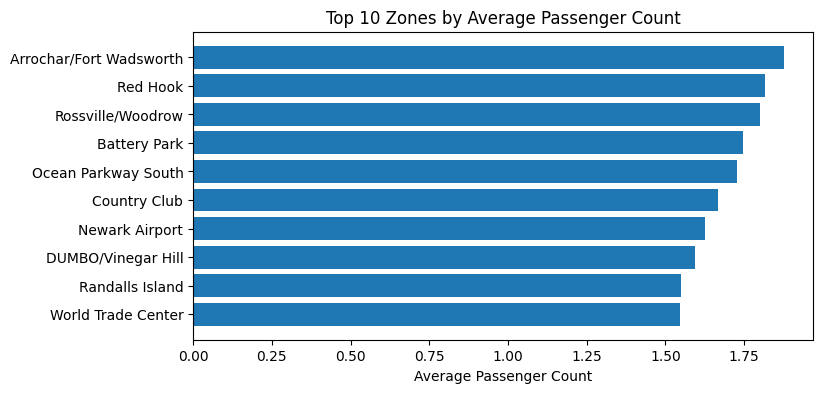

In [186]:
top10_zones = avg_passenger_zone_named.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top10_zones['zone'], top10_zones['avg_passenger_count'])
plt.xlabel('Average Passenger Count')
plt.title('Top 10 Zones by Average Passenger Count')
plt.gca().invert_yaxis()
plt.show()


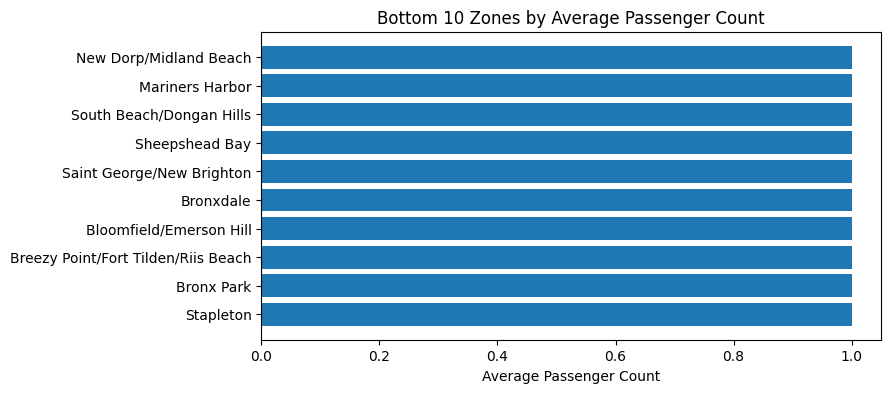

In [187]:
bottom10_zones = avg_passenger_zone_named.tail(10)

plt.figure(figsize=(8, 4))
plt.barh(bottom10_zones['zone'], bottom10_zones['avg_passenger_count'])
plt.xlabel('Average Passenger Count')
plt.title('Bottom 10 Zones by Average Passenger Count')
plt.gca().invert_yaxis()
plt.show()


In [188]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
avg_passenger_by_zone = (
    df.groupby('PULocationID')['passenger_count']
      .mean()
      .reset_index(name='avg_passenger_count')
)
zones_with_trips = zones_with_trips.merge(
    avg_passenger_by_zone,
    left_on='LocationID',
    right_on='PULocationID',
    how='left'
)

zones_with_trips['avg_passenger_count'] = (
    zones_with_trips['avg_passenger_count'].fillna(0)
)
zones_with_trips[['LocationID', 'zone', 'borough', 'avg_passenger_count']].head()


,LocationID,zone,borough,avg_passenger_count
0,1,Newark Airport,EWR,1.625000
1,2,Jamaica Bay,Queens,1.000000
2,3,Allerton/Pelham Gardens,Bronx,1.029412
3,4,Alphabet City,Manhattan,1.434617
4,5,Arden Heights,Staten Island,1.000000


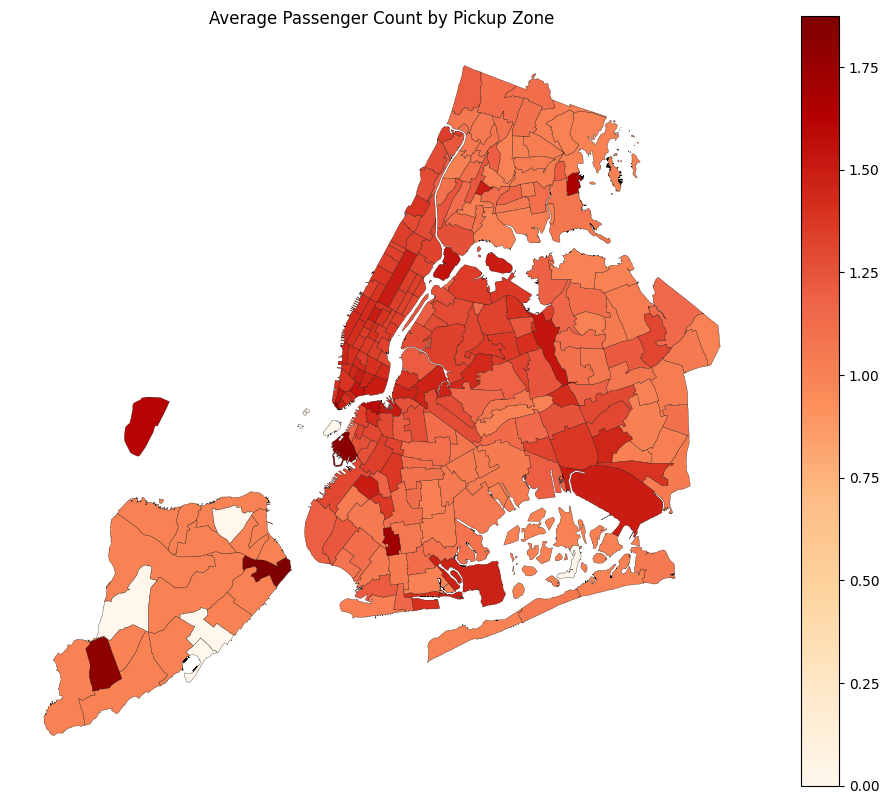

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

zones_with_trips.plot(
    column='avg_passenger_count',
    cmap='OrRd',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.2
)

ax.set_title('Average Passenger Count by Pickup Zone')
ax.axis('off')
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [190]:
# How often is each surcharge applied?

surcharge_cols = [
    'extra',
    'mta_tax',
    'improvement_surcharge',
    'congestion_surcharge',
    'airport_fee'
]
surcharge_summary = []

total_trips = len(df)

for col in surcharge_cols:
    applied_count = (df[col] > 0).sum()
    surcharge_summary.append({
        'Surcharge': col,
        'Trips_Applied': applied_count,
        'Percentage_of_Trips (%)': round(applied_count / total_trips * 100, 2)
    })

surcharge_summary_df = pd.DataFrame(surcharge_summary)
surcharge_summary_df


,Surcharge,Trips_Applied,Percentage_of_Trips (%)
0,extra,1131722,62.06
1,mta_tax,1807305,99.10
2,improvement_surcharge,1823330,99.98
3,congestion_surcharge,1686588,92.48
4,airport_fee,160617,8.81


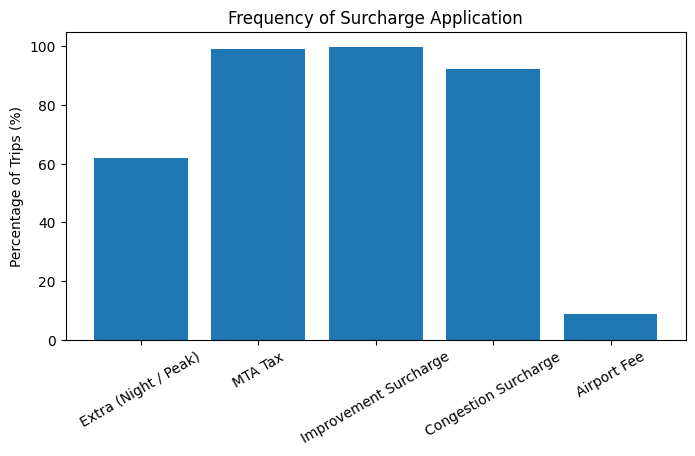

In [191]:
surcharge_summary_df['Surcharge'] = surcharge_summary_df['Surcharge'].map({
    'extra': 'Extra (Night / Peak)',
    'mta_tax': 'MTA Tax',
    'improvement_surcharge': 'Improvement Surcharge',
    'congestion_surcharge': 'Congestion Surcharge',
    'airport_fee': 'Airport Fee'
})
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(
    surcharge_summary_df['Surcharge'],
    surcharge_summary_df['Percentage_of_Trips (%)']
)
plt.ylabel('Percentage of Trips (%)')
plt.title('Frequency of Surcharge Application')
plt.xticks(rotation=30)
plt.show()


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**Time- and zone-aware dispatching**: Pre-position drivers in high-demand zones during peak afternoon/evening hours and weekends, and reduce supply in low-demand early-morning periods except near airports and hospitals.

**Congestion-aware routing**: Avoid assigning trips through historically slow routes during peak hours; dynamically reroute based on known low-speed corridors to reduce delays and fuel inefficiency.

**Pickup–dropoff imbalance correction**: Use pickup/dropoff ratios to proactively rebalance vehicles toward zones that consistently generate outbound demand.

**Nighttime optimization**: Increase driver availability in safe, high-demand night zones where surcharge frequency and tipping rates are higher, improving driver earnings and service availability.

**Occupancy-based matching**: Deploy larger vehicles to zones and times with higher average passenger counts (airports, tourist areas, weekends) to improve utilization.

**Predictive planning**: Leverage historical hourly and zone-level trends to forecast demand spikes and adjust dispatch density in advance rather than reacting to congestion.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**Peak-hour, high-demand zones**: Position more cabs in central business districts, transit hubs, and commercial areas during weekday mornings and evenings, when pickup volumes peak due to commuting activity.

**Evening and weekend hotspots**: Increase cab availability in entertainment, tourist, and waterfront zones during evenings and weekends, which show higher trip volumes, passenger counts, and tipping rates.

**Night-time strategy**: Deploy cabs selectively in safe, high-demand night zones (e.g., airports, hospitals, nightlife districts) during late-night and early-morning hours, when overall volume is lower but revenue per trip is higher due to surcharges.

**Seasonal and monthly adjustments**: Adjust fleet distribution based on monthly trends, scaling up availability during consistently high-demand months and reallocating cabs from low-demand periods to maintenance or driver rest.

**Zone rebalancing using pickup–dropoff ratios**: Continuously rebalance cabs toward zones with high pickup-to-dropoff ratios, ensuring vehicles are positioned where outbound demand is strongest and minimizing idle time.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

**Refine short-trip pricing:** Since fare per mile is highest for trips under 2 miles and differs across vendors, consider slightly lowering base fares or offering micro-discounts for short trips in high-competition zones to attract demand while preserving margins through higher trip volumes.

**Time-of-day pricing optimization**: Use historical demand and congestion data to fine-tune peak and night surcharges, ensuring they align with actual congestion and willingness-to-pay rather than being uniformly applied across all zones.

**Distance-tier smoothing:** As fare efficiency converges for longer trips, maintain competitive, stable per-mile rates for trips over 5 miles to encourage high-value, long-distance journeys and airport runs.

**Zone-sensitive pricing**: Apply location-based pricing adjustments in zones with consistently high demand, high pickup-dropoff imbalance, or frequent congestion, while offering competitive rates in low-demand zones to stimulate usage.

**Vendor benchmarking**: Continuously compare vendor-wise fare per mile across distance tiers to avoid overpricing in short trips, where vendor differences are most noticeable and customer sensitivity is highest.

**Payment-linked incentives**: Encourage card-based payments through small incentives, as these trips are associated with higher recorded tips and smoother fare realization, improving total effective revenue without raising base fares.